# Lungs Segmentation
The segmentation of lungs may, possibly, proceed directly in 3D as follows:
1. Run binarization of the CT image using a threshold of -320 HU – every voxel
with HU lower than this threshold should receive label 1 (air label) and the
remaining voxels should receive label 0
2. Use body mask to select only air regions within body
3. Design a sequence of morphological (and other appropriate) operations to fill
the holes in the interior of lungs and to remove ‘air’ clusters which do not
correspond to lungs (e.g. gas in bowels) – at the end one should be left with
clusters which correspond only to airways
4. Use watershed from markers (scikit-image -> segmentation -> watershed) to
extract the left and the right lung from the segmentation being the result of step
(3) above. Before using watershed design a procedure for defining the three
markers (marker of left lung, marker of right lung, marker of background).
5. To compare segmentation results with reference segmentations available at
Lab One Drive use Dice coefficient and Hausdorff distance (find the definitions of
these   quantities)   as   implemented   in   surface-distance   [package](https://github.com/google-deepmind/surface-distance).
The project results (Dice coefficients and Hausdorff distance) should be
reported   for   the   three   tasks:   body   mask   segmentation,   left   lung
segmentation, right lung segmentation.


## Imports

In [118]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from scipy import ndimage
import matplotlib.pyplot as plt
# from pycimg import CImg

import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import reconstruction
from skimage.segmentation import flood, flood_fill
from sklearn import cluster
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt

from surface_distance import metrics

## Load / save .nii files and Visualization

In [119]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photo(img: np.ndarray, photo_title: str,  *slices: int) -> None:
    print(f"Visualizing {photo_title}")
    plt.figure(figsize=(5 * len(slices), 5)) 
    
    for i, slice_num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.title(f"photo Slice {slice_num}")
        plt.imshow(img[:, :, slice_num], cmap="gray")
        
    plt.tight_layout() 
    plt.show()
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()

## 1. Body differentiation

In [120]:
def binarize_otsu(img: np.ndarray) -> np.ndarray:
    threshold = filters.threshold_otsu(img)
    print("Otsu threshold: ", threshold)
    return img > threshold


def find_active_range(img: np.ndarray, size: int = 70) -> tuple:
    hist, _ = np.histogram(img, bins=256)    
    max_s = float('-inf')
    s = 0
    max_i = size
    
    for i in range(size):
        s += hist[i]
    
    for i in range(size, 256):
        s -= hist[i - size]
        s += hist[i]
        if s > max_s:
            max_s = s
            max_i = i
    
    return (max_i - size, max_i)

def custom_binarization(img: np.ndarray, active_range: tuple) -> np.ndarray:
    l, r = active_range
    thr = (r - l) // 2 + l
    print("Custom threshold: ", thr)
    return img > thr
    

def adaptive_gaussian_threshold_3d(img: np.ndarray, block_size: int = 11, c: int = 2) -> np.ndarray:
    binarized_img = np.zeros_like(img)
    for i in range(img.shape[2]):
        binarized_img[:, :, i] = cv2.adaptiveThreshold(img[:, :, i], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)
    return binarized_img

    
def binarize_images_dual_threshold(image: np.ndarray, body_mask: np.ndarray, low_threshold: float = -320, high_threshold: float = -100) -> np.ndarray:
    return (image > low_threshold) * (image < high_threshold) * body_mask

def binarize_images_kmeans(image: np.ndarray, max_iter: int = 100) -> np.ndarray:
    min_val = image.min()
    not_background = image > min_val
    img_not_background = image * not_background
    
    threshold = img_not_background.sum() / not_background.sum()
    prev_threshold = 0
    
    for _ in range(max_iter):
        foreground_mask = image > threshold
        background_mask = image <= threshold
        
        foreground = img_not_background * foreground_mask
        background = img_not_background * background_mask
        
        avg_foreground = foreground.sum() / foreground_mask.sum()
        avg_background = background.sum() / background_mask.sum()
        
        new_threshold = (avg_foreground + avg_background) / 2
        
        if abs(new_threshold - prev_threshold) < 0.1:
            threshold = new_threshold
            break
        
        prev_threshold = threshold
        threshold = new_threshold
    
    print(f"Threshold: {threshold}")
        
    image = (image > threshold) * not_background
    return image.astype(np.uint8)

## Body Mask

In [121]:
def prepare_before_body_mask(img: np.ndarray, active_range: tuple) -> np.ndarray:
    binary_image = custom_binarization(img, active_range)
    # binary_image = binarize_images_kmeans(img)
    # binary_image = binarize_otsu(img)
    # grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # binary_image = adaptive_gaussian_threshold_3d(img)
    binary_image = ndimage.binary_fill_holes(binary_image)
    binary_image = morphology.binary_opening(binary_image, morphology.ball(2))
    binary_image = morphology.binary_closing(binary_image, morphology.ball(2))
    return binary_image

def resize_3d_image(img: np.ndarray, output_shape: tuple) -> np.ndarray:
    sizes = img.shape
    resized_img = np.zeros((output_shape[0], output_shape[1], sizes[2]), dtype=img.dtype)
    
    for i in range(img.shape[2]):
        resized_img[:,:,i] = cv2.resize(img[:,:,i], (output_shape[0], output_shape[1]), interpolation=cv2.INTER_LINEAR) 
    
    return resized_img

def equalize_hist_3d(img: np.ndarray) -> np.ndarray:
    sizes = img.shape
    equalized_img = np.zeros_like(img)
    
    for i in range(sizes[2]):
        equalized_img[:,:,i] = cv2.equalizeHist(img[:,:,i])
    
    return equalized_img

def reconstruct_3d(img: np.ndarray) -> np.ndarray:
    labels = label(img, connectivity=1)
    regions = regionprops(labels)
    largest_region = max(regions, key=lambda x: x.area)
    largest_region_mask = labels == largest_region.label
    
    mask = largest_region_mask
    neg_mask = np.logical_not(mask)
    
    seed = np.zeros_like(mask)
    list_of_corners = [(0, 0, 0), (0, 0, -1), (0, -1, 0), (-1, 0, 0), (-1, -1, -1), (-1, -1, 0), (-1, 0, -1), (0, -1, -1)]
    for corner in list_of_corners:
        seed[corner] = 1
    
    reconstructed = reconstruction(seed, neg_mask)
    insert_part = 1 - reconstructed
    
    return insert_part

def create_body_mask(img: np.ndarray) -> np.ndarray:
    binary_image = prepare_before_body_mask(img)
    body_mask = reconstruct_3d(binary_image)
    return body_mask

def medianBlur(img: np.ndarray, kernel_size: int) -> np.ndarray:
    sizes = img.shape
    blurred = np.zeros_like(img)
    
    for i in range(sizes[2]):
        blurred[:,:,i] = cv2.medianBlur(img[:,:,i], kernel_size)
    
    return blurred

def bilateralFilter(img: np.ndarray, d: int, sigma_color: int, sigma_space: int) -> np.ndarray:
    sizes = img.shape
    filtered = np.zeros_like(img)
    
    for i in range(sizes[2]):
        filtered[:,:,i] = cv2.bilateralFilter(img[:,:,i], d, sigma_color, sigma_space)
    
    return filtered

## Lungs segmentation

In [122]:

def get_largest_region(img: np.ndarray) -> np.ndarray:
    binary_image = binarize_images_kmeans(img)
    labels = label(binary_image, connectivity=1)
    regions = regionprops(labels)
    largest_region = max(regions, key=lambda x: x.area)
    return labels == largest_region.label

def plot_histogram(img: np.ndarray) -> None:
    plt.hist(img.ravel(), bins=256, range=(img.min()+1, img.max()-1), fc='k', ec='k')
    plt.show()
    
def find_lung_histogram_peak(img: np.ndarray, active_range: tuple) -> float:
    l, r = active_range
    m = (r - l) // 2 + l
    histogram = np.histogram(img, bins=256, range=(l, m))
    lung_peak_index = np.argmax(histogram[0][1:]) + 1
    lung_peak_value = histogram[1][lung_peak_index]
    return lung_peak_value

def kmeans_clusterization(img: np.ndarray) -> np.ndarray:
    markers = np.stack(np.where(img), axis=-1)    
    clusters = cluster.KMeans(n_clusters=2)
    points = clusters.fit_predict(markers)
    return points, clusters.cluster_centers_


def watershed_segmentation(img: np.ndarray, centers: tuple) -> np.ndarray:
    markers = np.zeros(img.shape, dtype=np.int32)

    for i, center in enumerate(centers):
        center_3d_point = tuple(np.round(center).astype(int))
        print(f"Center point {center_3d_point}")

        if 0 <= center_3d_point[0] < img.shape[0] and 0 <= center_3d_point[1] < img.shape[1]:
            markers[center_3d_point] = i + 1  
            
    distance_map = distance_transform_edt(img)
    return watershed(-distance_map, markers, mask=img)

def cut_out_body(img: np.ndarray, body_mask: np.ndarray) -> np.ndarray:
    min_val = img.min()
    img = img * body_mask + min_val * (1 - body_mask)
    visualize_photo(img, "cut image", 50, 70, 100, 120)
    
# delta decrease the active range for dual threshold
def lungs_initial_transform(img: np.ndarray, body_mask: np.ndarray, active_range: tuple, delta=10) -> np.ndarray:
    cut_out_body(img, body_mask)
    plot_histogram(img)
    lung_peak_value = find_lung_histogram_peak(img, active_range)
    
    print(f"Lung peak value: {lung_peak_value}")
        
    l, r = active_range
    range_size = r - l - delta
    binary_image = binarize_images_dual_threshold(img, body_mask, max(lung_peak_value - (range_size // 2), img.min() + 1), lung_peak_value + (range_size // 2))
    binary_image = ndimage.binary_fill_holes(binary_image)
    binary_image = morphology.binary_closing(binary_image, morphology.ball(3))
    binary_image = morphology.binary_closing(binary_image, morphology.ball(3))
    binary_image = morphology.binary_opening(binary_image, morphology.ball(3))
    return binary_image

## Compare with reference

In [123]:
class Scores:
    def __init__(self, img: np.ndarray, ref_img: np.ndarray, centers: np.ndarray, body_masks: np.ndarray, body_masks_ref: np.ndarray) -> None:
        self.img: np.ndarray = img
        self.ref_img: np.ndarray = ref_img
        self.body_masks = body_masks
        self.body_masks_ref = body_masks_ref
        plt.imshow(self.img[..., 80], cmap='gray')
        plt.show()
        self.centers = centers
        self.my_left_lung, self.my_right_lung = self.__get_lungs_from_labels(image=self.img, left_label=1, right_label=2)
        self.ref_left_lung, self.ref_right_lung = self.__get_lungs_from_labels(image=self.ref_img, left_label=2, right_label=3)
        
    def __get_lungs_from_labels(self, image: np.ndarray, left_label: int, right_label: int) -> tuple[np.ndarray, np.ndarray]:
        left_lung = np.where(image == left_label, 1, 0)
        right_lung = np.where(image == right_label, 1, 0)
        return left_lung, right_lung
        
    def calculate_dice_coef(self)-> tuple[np.float64, np.float64]:
        dice_coef_left = metrics.compute_dice_coefficient(self.my_left_lung.astype(np.bool), self.ref_left_lung.astype(np.bool))
        dice_coef_right = metrics.compute_dice_coefficient(self.my_right_lung.astype(np.bool), self.ref_right_lung.astype(np.bool))
        dice_coef_body_masks = metrics.compute_dice_coefficient(self.body_masks.astype(np.bool), self.body_masks_ref.astype(np.bool))
        return dice_coef_left, dice_coef_right, dice_coef_body_masks
    
    def caculate_hausdorff_distance(self) -> tuple[np.float64, np.float64]:
        left_surf_distances = metrics.compute_surface_distances(self.my_left_lung.astype(np.bool), self.ref_left_lung.astype(np.bool), (1, 1, 1))
        right_surf_distances = metrics.compute_surface_distances(self.my_right_lung.astype(np.bool), self.ref_right_lung.astype(np.bool), (1, 1, 1))
        body_mask_distances = metrics.compute_surface_distances(self.body_masks.astype(np.bool), self.body_masks_ref.astype(np.bool), (1, 1, 1))
        
        hausdorff_left = metrics.compute_robust_hausdorff(left_surf_distances, 95)
        hausdorff_right = metrics.compute_robust_hausdorff(right_surf_distances, 95)
        hausdorff_body_mask = metrics.compute_robust_hausdorff(body_mask_distances, 95)
        
        return hausdorff_left, hausdorff_right, hausdorff_body_mask
    
    def plot_lungs(self) -> None:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.title('My left lung')
        plt.imshow(self.my_left_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 2)
        plt.title('Reference left lung')
        plt.imshow(self.ref_left_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 3)
        plt.title('My right lung')
        plt.imshow(self.my_right_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 4)
        plt.title('Reference right lung')
        plt.imshow(self.ref_right_lung[..., 50], cmap='gray')
        plt.show()

## Main

In [124]:
def run(img_path: str,reference_img_path: str, body_mask_path: str) -> tuple:
    print(f"~~~ {img_path} ~~~")
    # load images
    img, affine = load_nii_gz_file(img_path)
    body_masks_ref, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # transform
    sizes = img.shape
    resized_img = resize_3d_image(img, (sizes[0] // 2, sizes[1] // 2))
    img = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    blured = medianBlur(img, 5)
    # blured = bilateralFilter(img, 3, 10, 10)
    # visualize_photo(blured, "blured", 50, 70, 100, 120)
    
    # plot_histogram(blured)
    active_range = find_active_range(blured)
    img_for_mask = prepare_before_body_mask(blured, active_range)  
    body_mask = reconstruct_3d(img_for_mask)
    # visualize_photo(blured, "body_mask", 50, 70, 100, 120)
    
    lungs = lungs_initial_transform(blured, body_mask, active_range)
    visualize_photo(lungs, "lungs", 50, 70, 100, 120)
    _, centers = kmeans_clusterization(lungs)
    
    # sorting centers by x coordinate
    centers = centers[centers[:, 1].argsort()]
    
    result = watershed_segmentation(lungs, centers)
    visualize_photo(result, "watershed", 50, 70, 100, 120)
    body_mask = resize_3d_image(body_mask.astype("float32"), (sizes[0], sizes[1]))
    result = resize_3d_image(result.astype("float32"), (sizes[0], sizes[1]))
 
    
    scores = Scores(result, reference_img, centers, body_mask, body_masks_ref)
    left_dice_score, right_dice_score, body_masks_score = scores.calculate_dice_coef()
    print(f"Left lung dice coefficient: {left_dice_score}, Right lung dice coefficient: {right_dice_score}, Body masks dice coefficient: {body_masks_score}")
    left_hausdorff, right_hausdorff, body_mask_hausdorff = scores.caculate_hausdorff_distance()
    print(f"Left lung hausdorff: {left_hausdorff}, Right lung hausdorff: {right_hausdorff}, Body masks hausdorff: {body_mask_hausdorff}")
    
    # visualize
    # visualize_photos(body_mask, body_masks, abs(body_mask - body_masks), 50, 70, 100, 120)
    # visualize_photos(lungs.img, reference_img, abs(lungs.img - (reference_img > 1) * 1), 50, 70, 100, 120)
    scores.plot_lungs()
    
    return left_dice_score, right_dice_score, body_masks_score
    

## Run code

In [125]:
def run_all_tests(inputs, references, body_masks):
    left_scors = []
    right_scores = []
    body_mask_scores = []
    for i in range(len(inputs)):
        cur_input = inputs[i]
        reference = references[i]
        body_mask = body_masks[i]
        left, right, body_masks_score = run(cur_input, reference, body_mask)
        left_scors.append(left)
        right_scores.append(right)
        body_mask_scores.append(body_masks_score)
        
    avg_left = sum(left_scors) / len(left_scors)
    avg_right = sum(right_scores) / len(right_scores)
    body_masks_avg = sum(body_mask_scores) / len(body_mask_scores)
    
    print(f"Average left lung dice coefficient: {avg_left}, Average right lung dice coefficient: {avg_right}, Average body masks dice coefficient: {body_masks_avg}")

~~~ Images/IMG_0001.nii.gz ~~~
Custom threshold:  85
Visualizing cut image


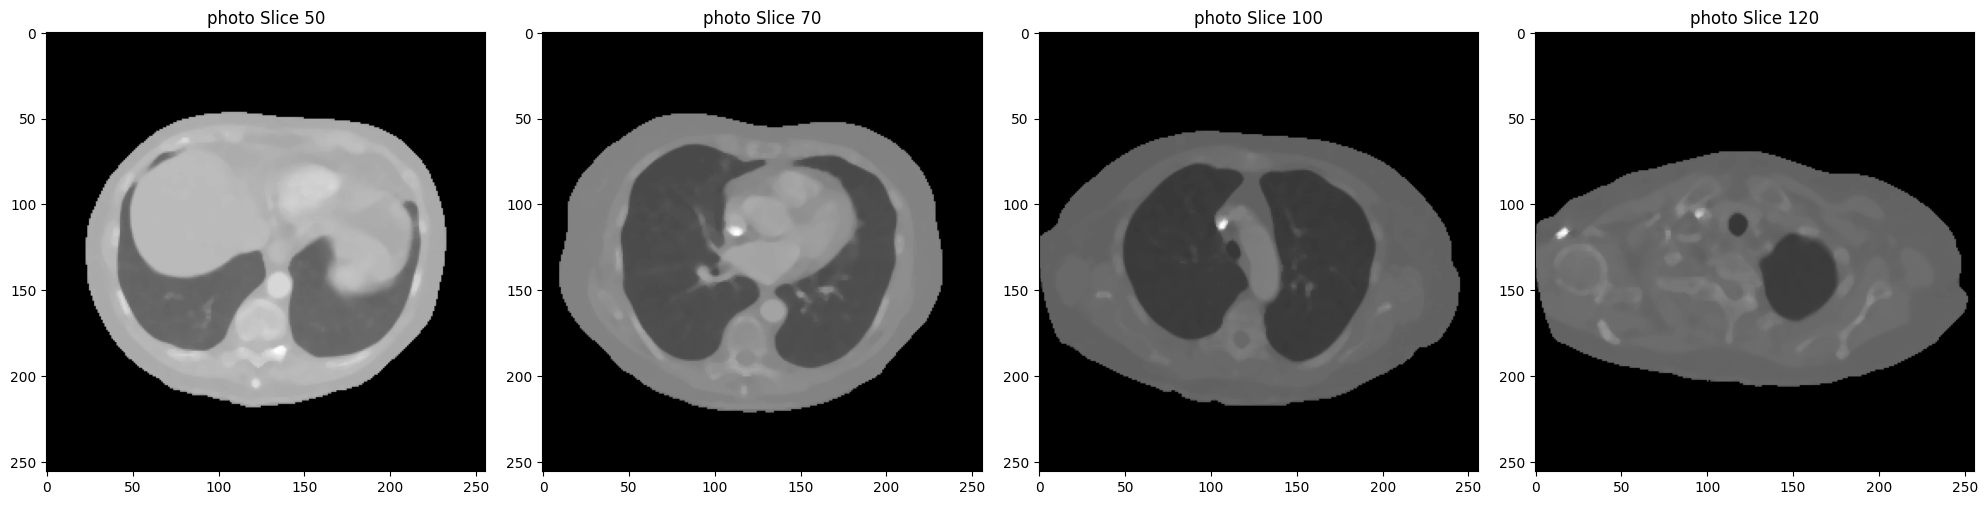

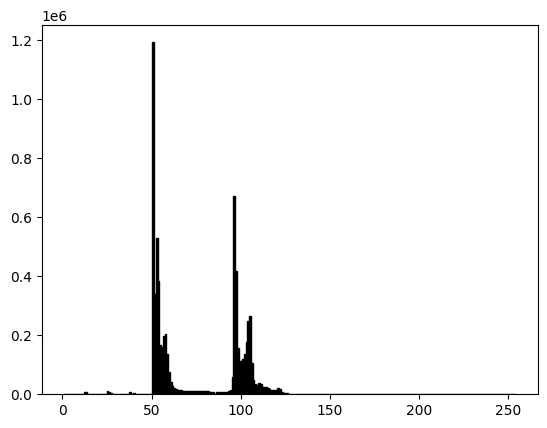

Lung peak value: 50.95703125
Visualizing lungs


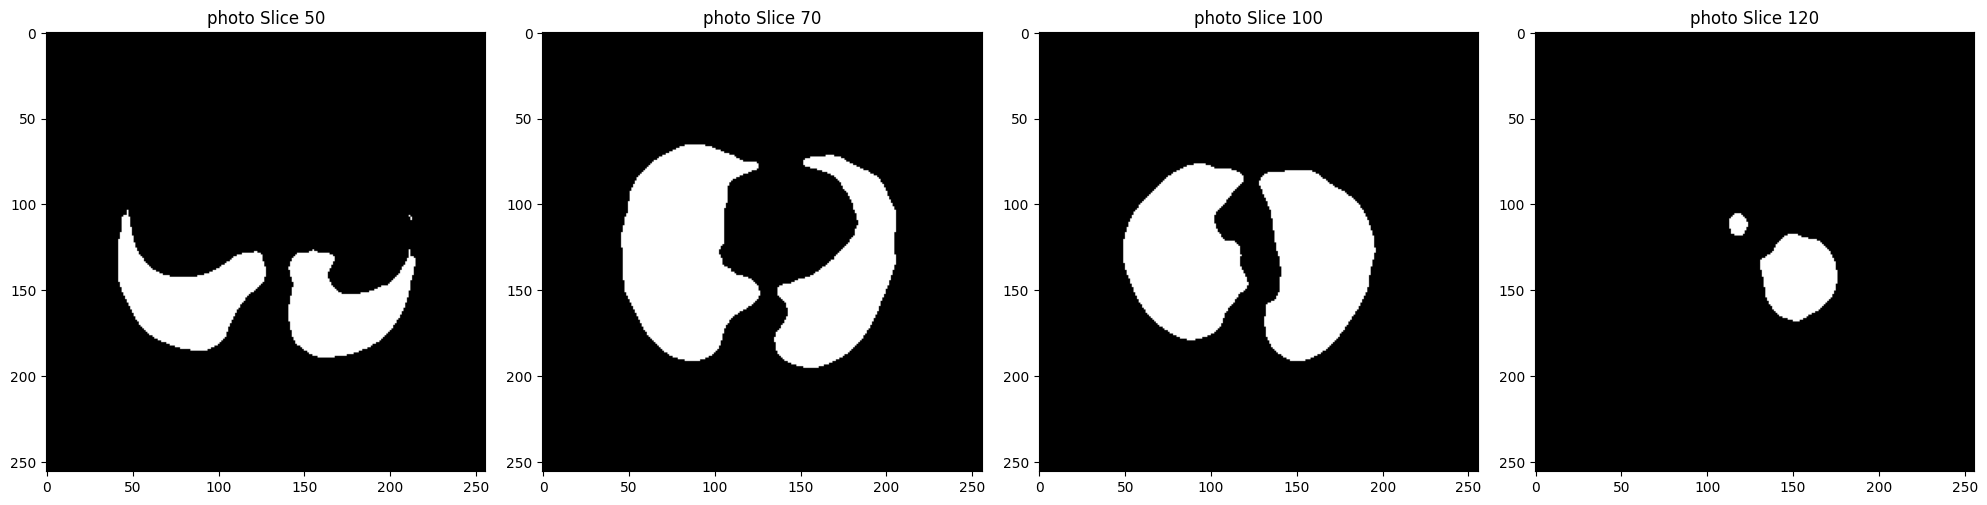

Center point (np.int64(133), np.int64(83), np.int64(76))
Center point (np.int64(140), np.int64(167), np.int64(82))
Visualizing watershed


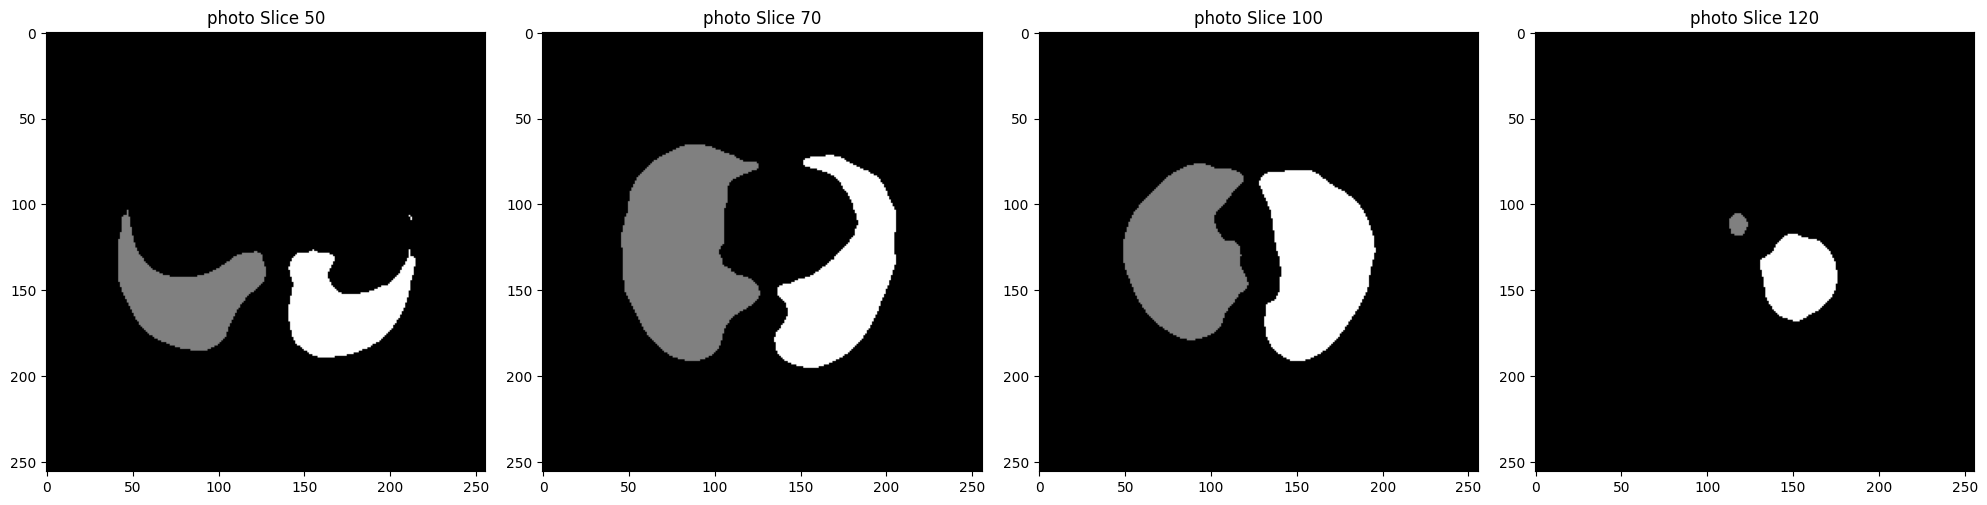

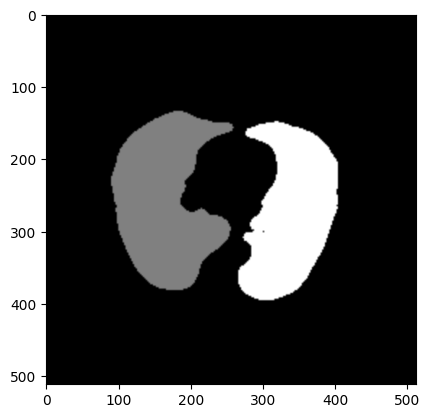

Left lung dice coefficient: 0.9617579302016758, Right lung dice coefficient: 0.9612599881999024, Body masks dice coefficient: 0.9907380836146379
Left lung hausdorff: 4.123105625617661, Right lung hausdorff: 5.196152422706632, Body masks hausdorff: 2.0


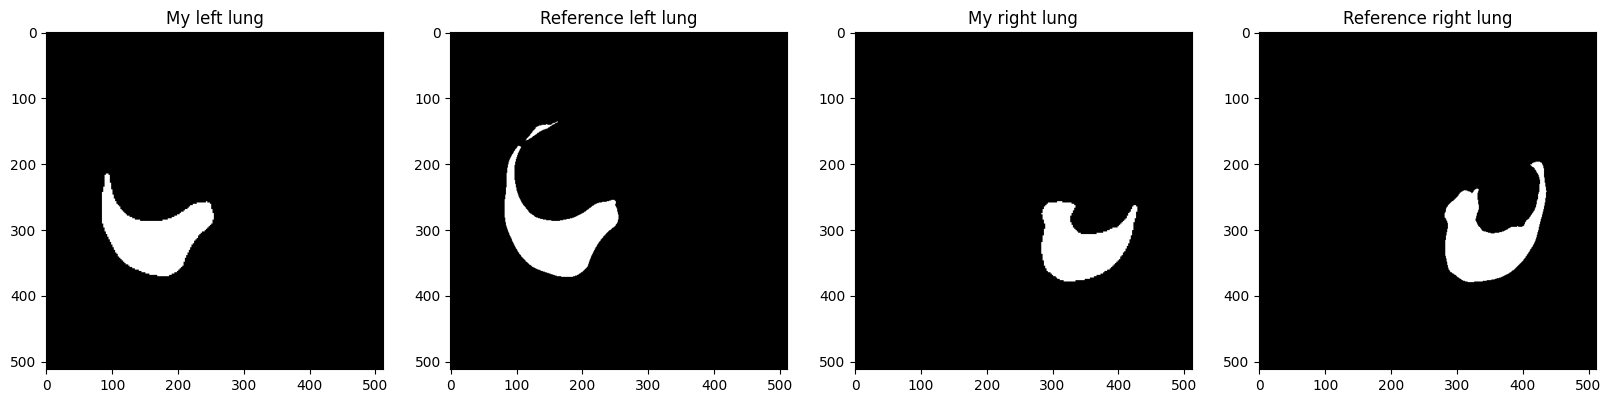

~~~ Images/IMG_0007.nii.gz ~~~
Custom threshold:  85
Visualizing cut image


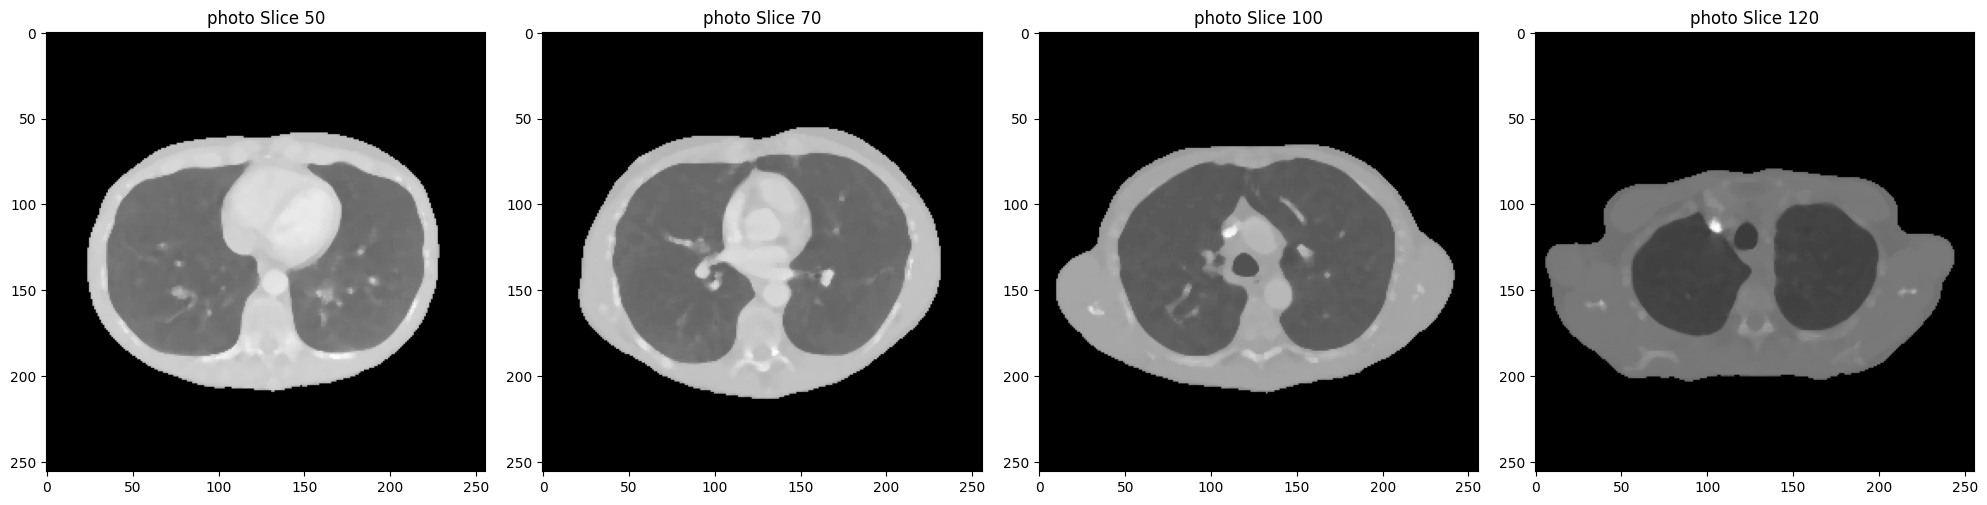

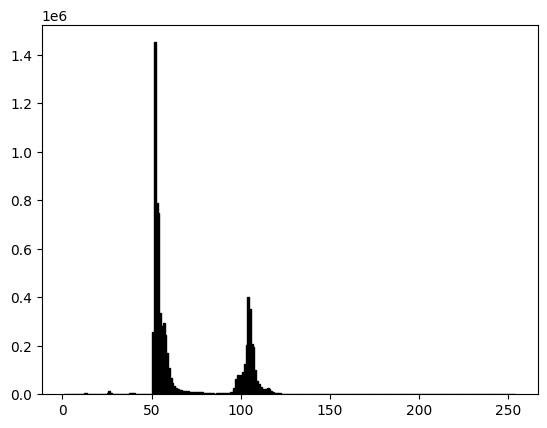

Lung peak value: 51.9140625
Visualizing lungs


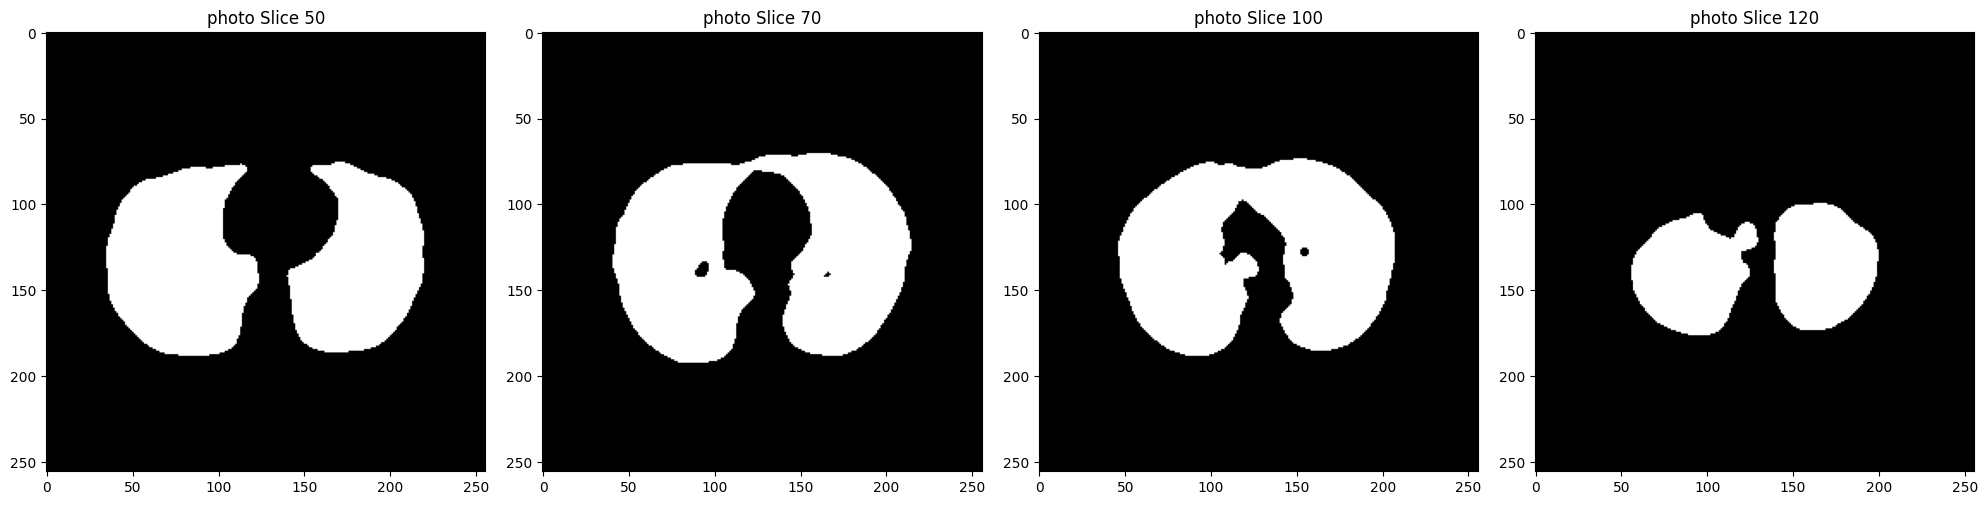

Center point (np.int64(134), np.int64(82), np.int64(76))
Center point (np.int64(130), np.int64(174), np.int64(77))
Visualizing watershed


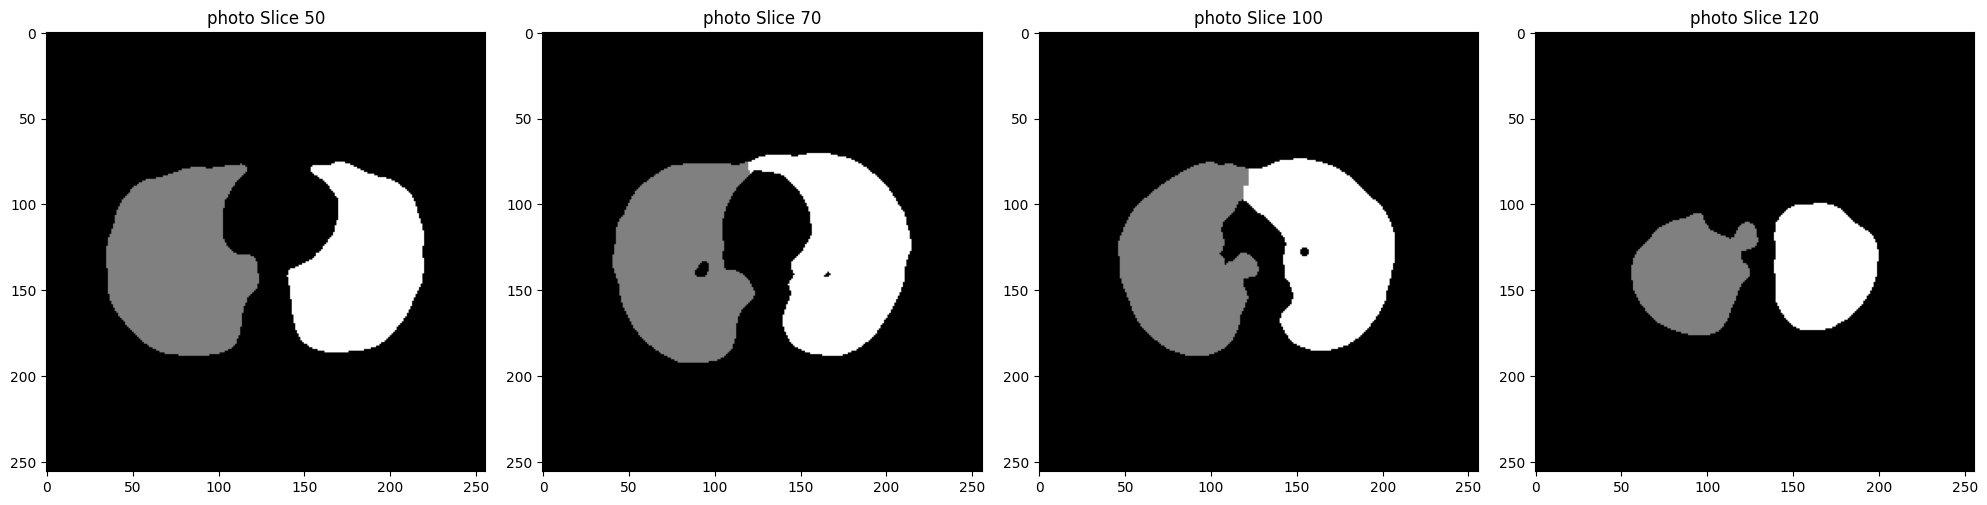

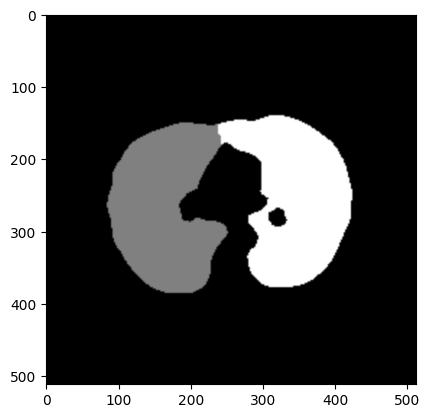

Left lung dice coefficient: 0.9647941746512129, Right lung dice coefficient: 0.963101098531281, Body masks dice coefficient: 0.98996148246387
Left lung hausdorff: 7.3484692283495345, Right lung hausdorff: 5.385164807134504, Body masks hausdorff: 2.23606797749979


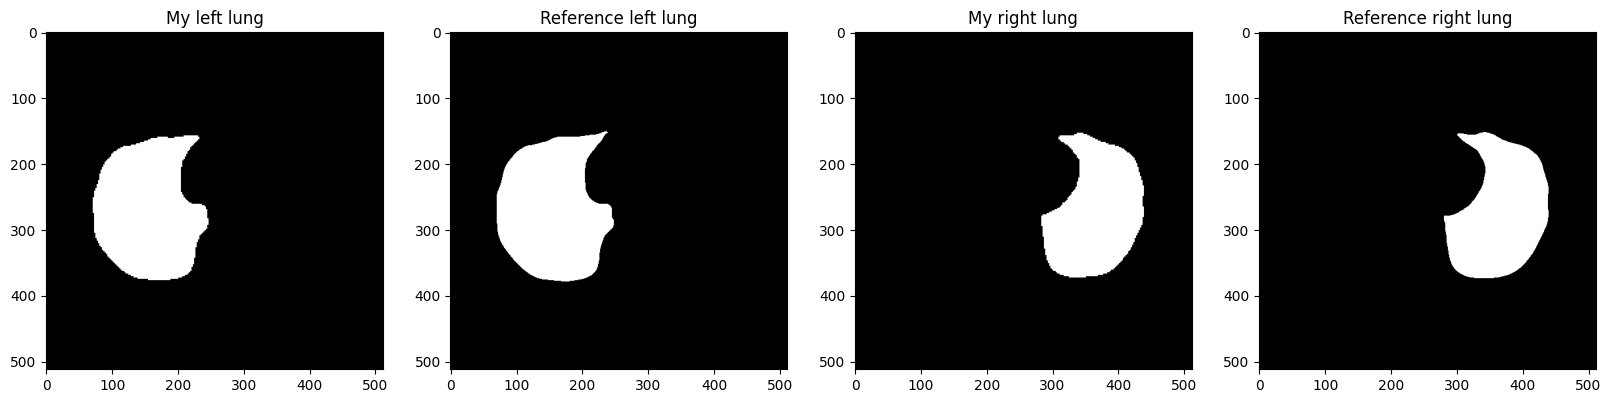

~~~ Images/IMG_0010.nii.gz ~~~
Custom threshold:  117
Visualizing cut image


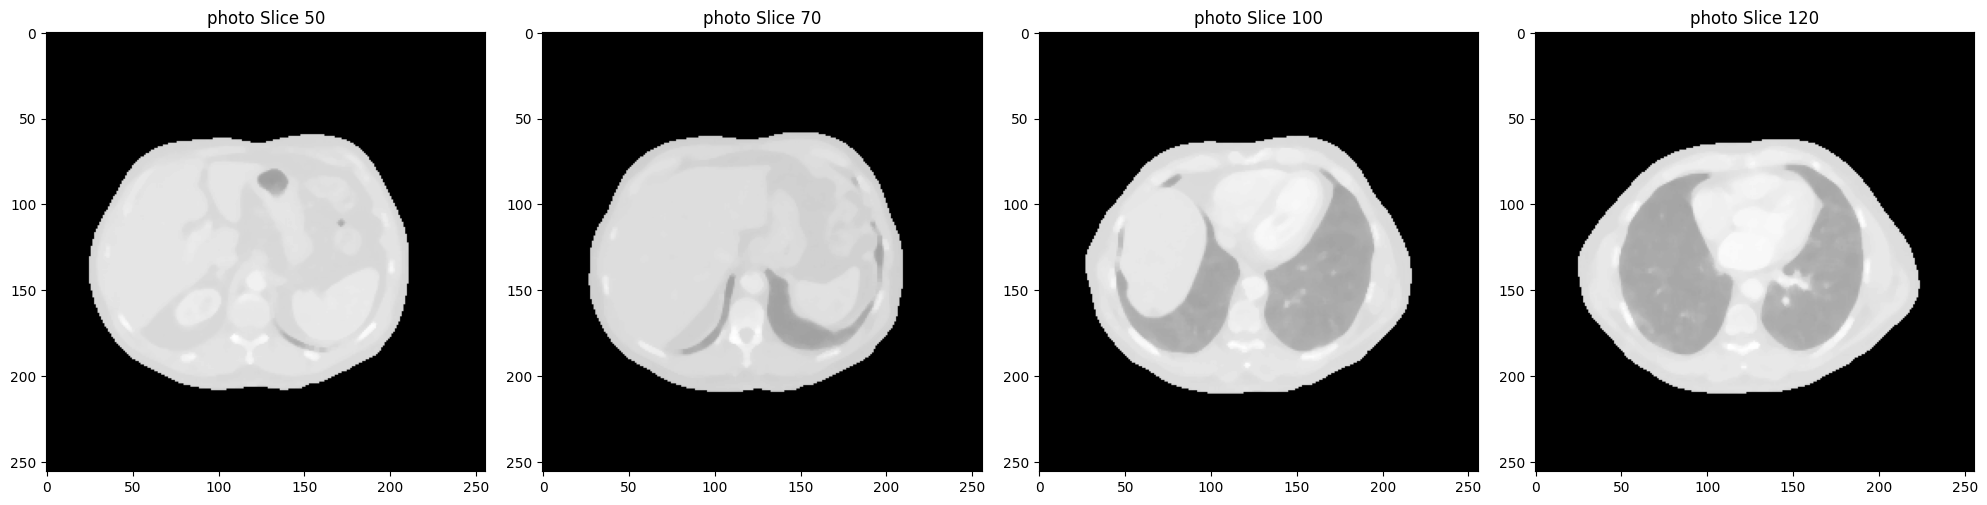

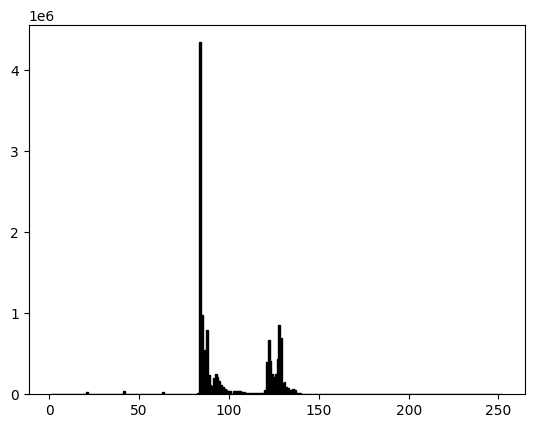

Lung peak value: 83.9140625
Visualizing lungs


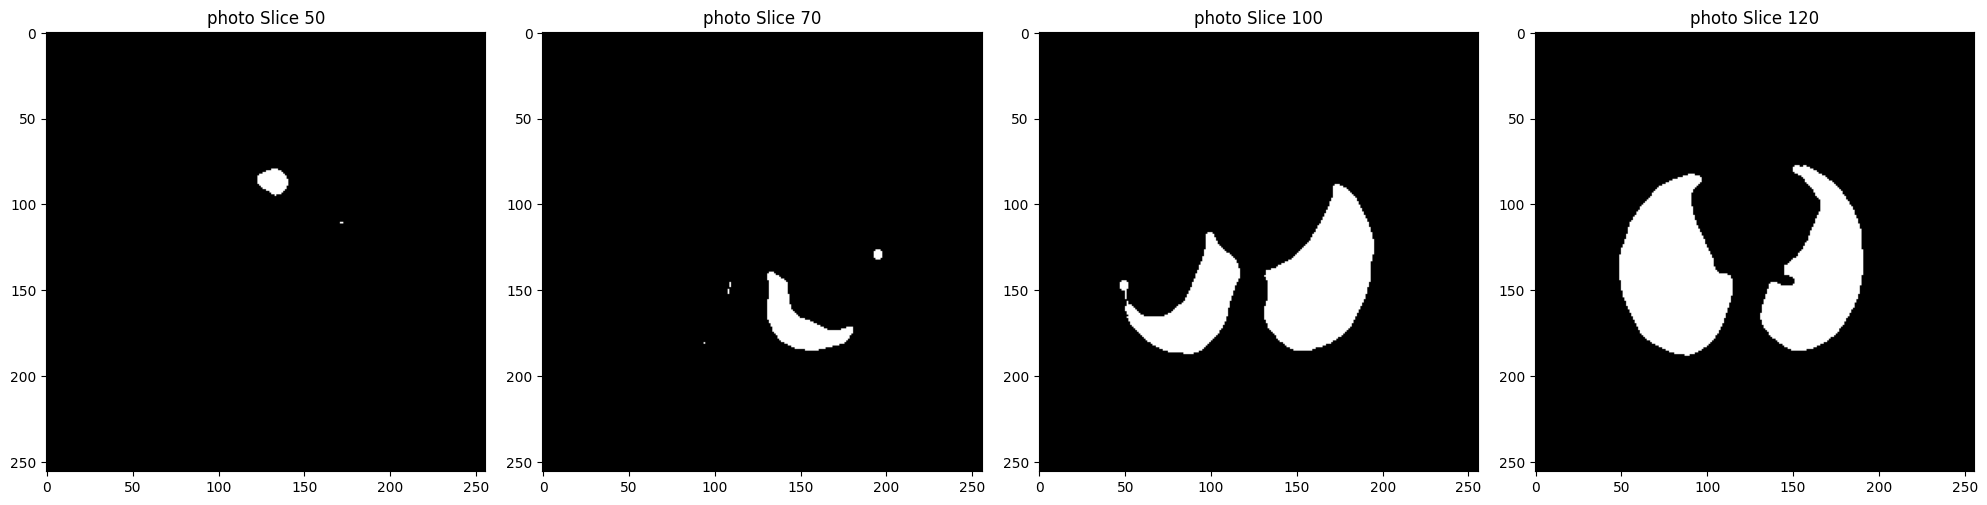

Center point (np.int64(142), np.int64(86), np.int64(155))
Center point (np.int64(137), np.int64(160), np.int64(140))
Visualizing watershed


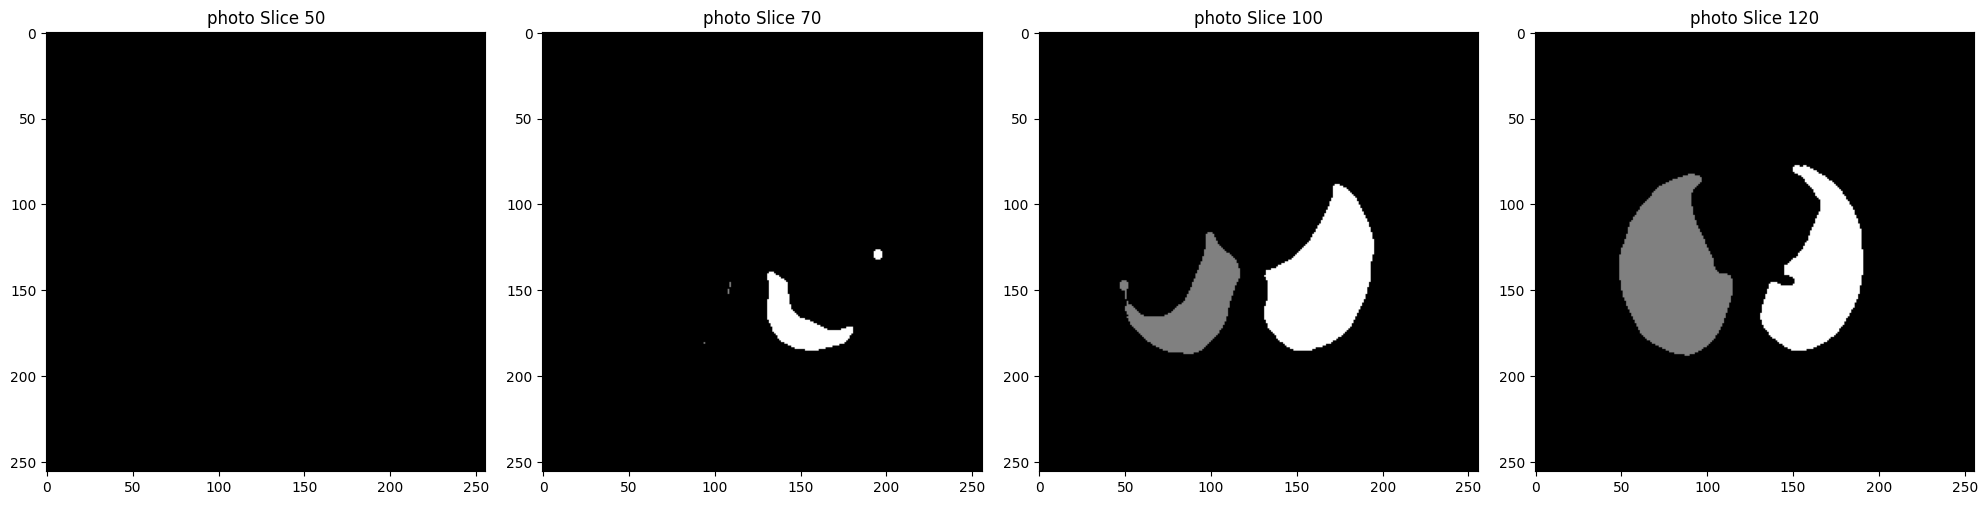

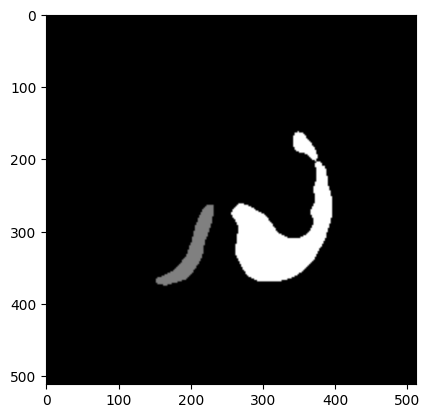

Left lung dice coefficient: 0.9564294705192748, Right lung dice coefficient: 0.9634155459948506, Body masks dice coefficient: 0.9925801362227799
Left lung hausdorff: 9.539392014169456, Right lung hausdorff: 7.280109889280518, Body masks hausdorff: 1.4142135623730951


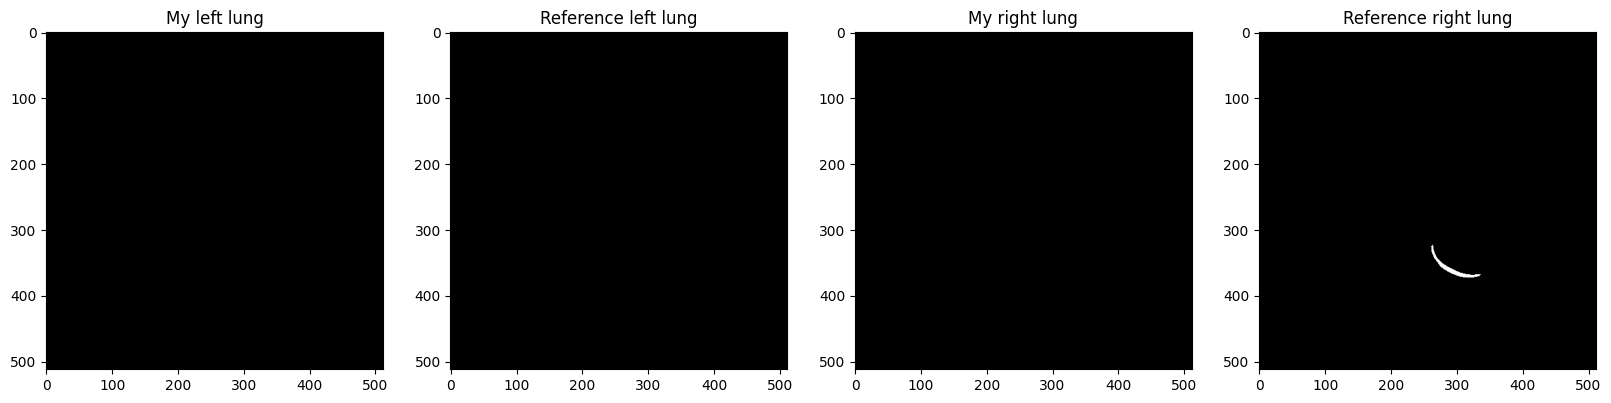

~~~ Images/IMG_0011.nii.gz ~~~
Custom threshold:  85
Visualizing cut image


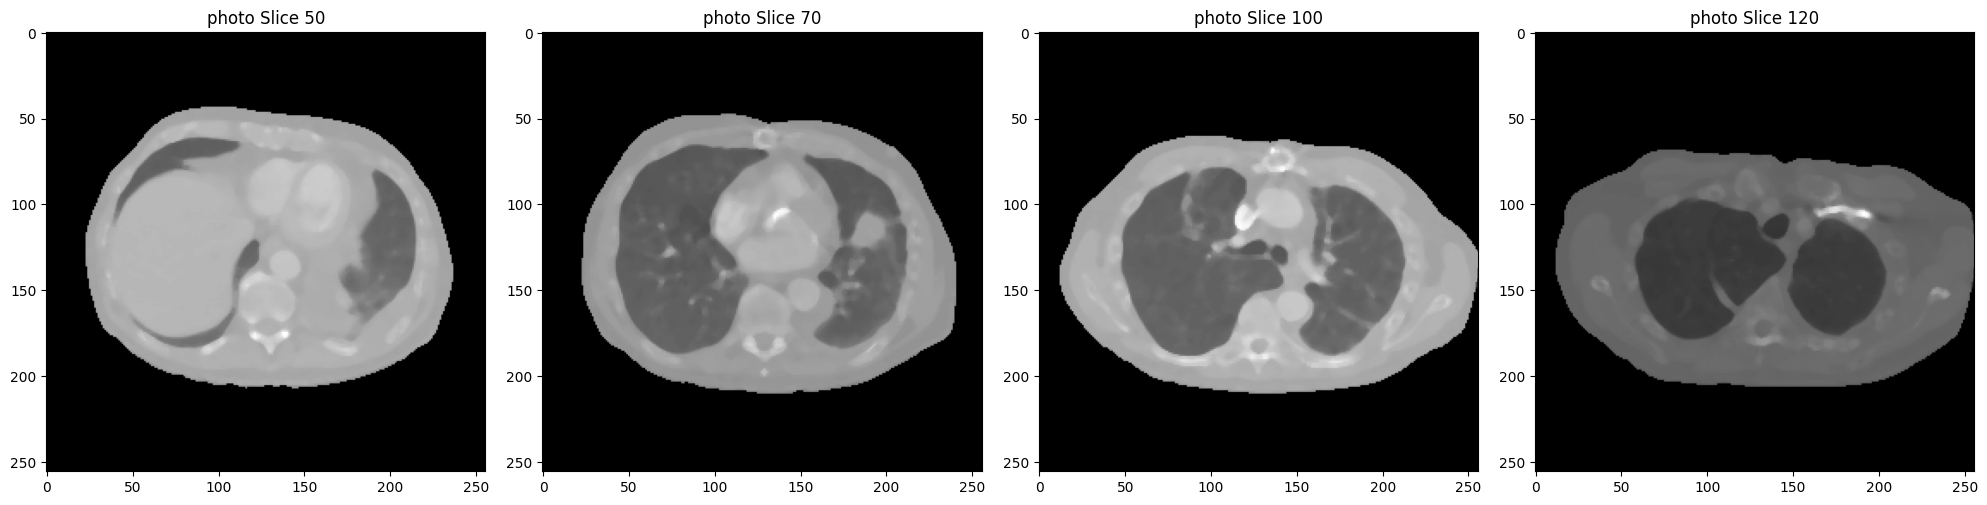

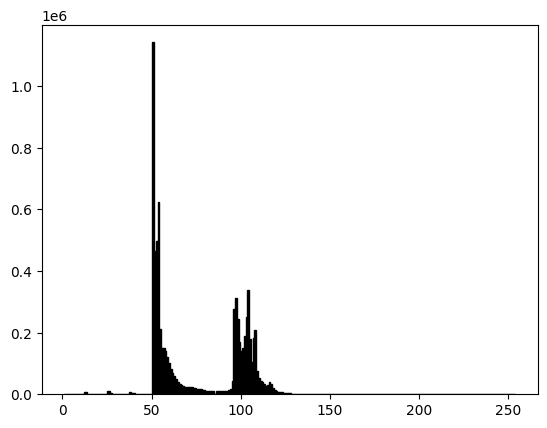

Lung peak value: 50.95703125
Visualizing lungs


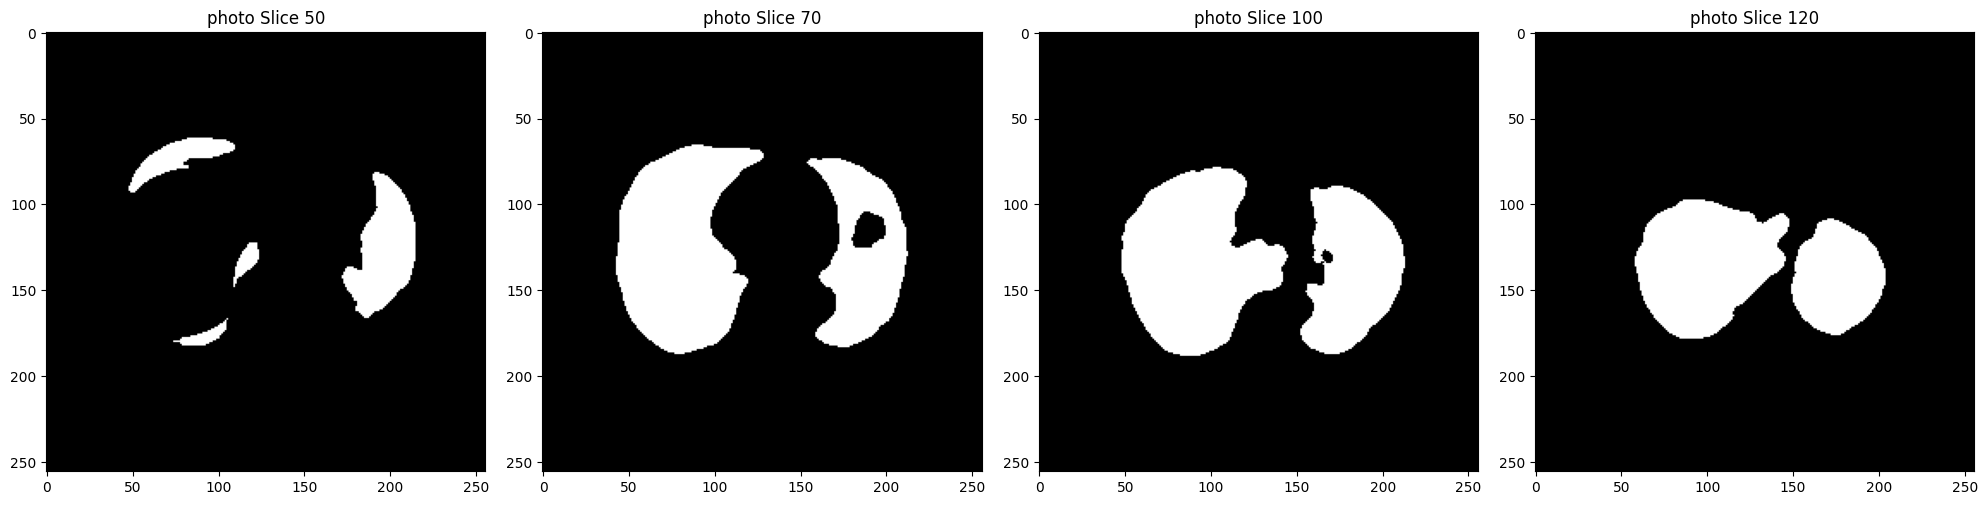

Center point (np.int64(129), np.int64(88), np.int64(89))
Center point (np.int64(130), np.int64(180), np.int64(84))
Visualizing watershed


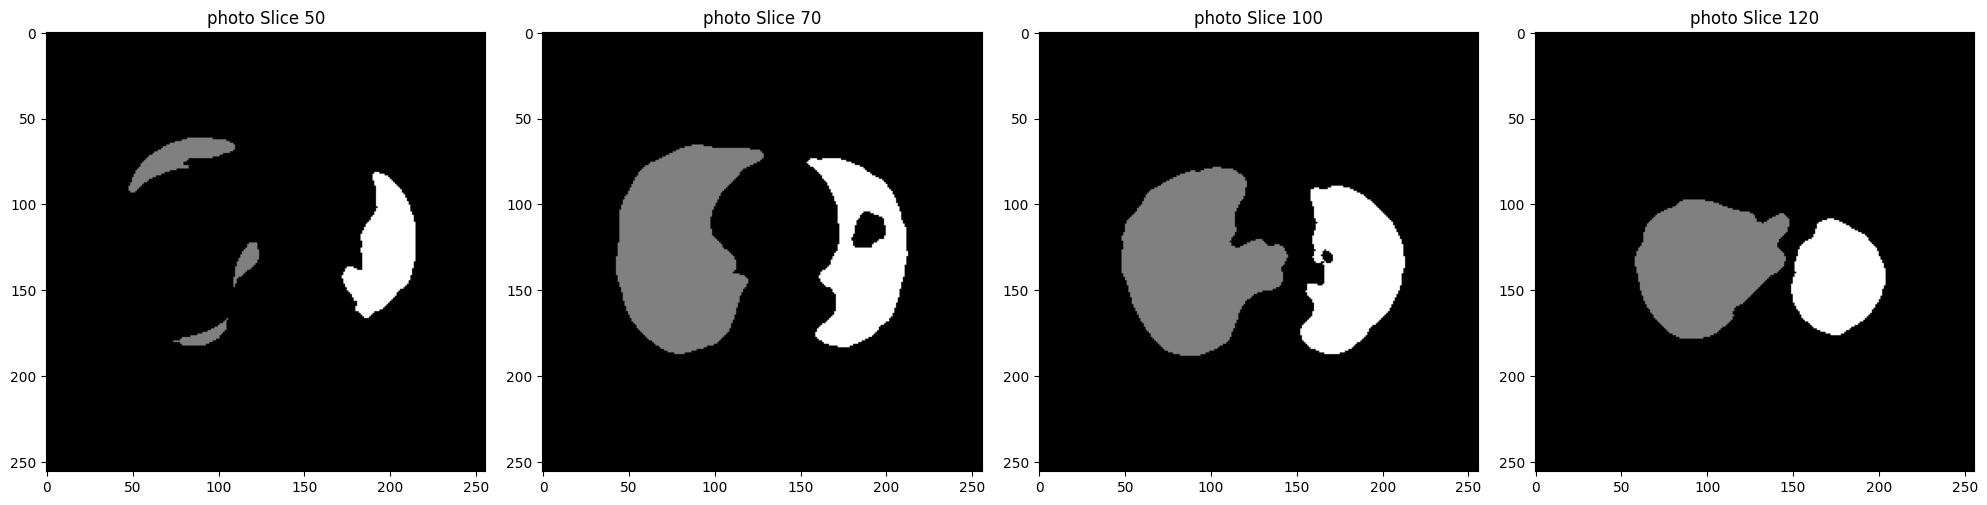

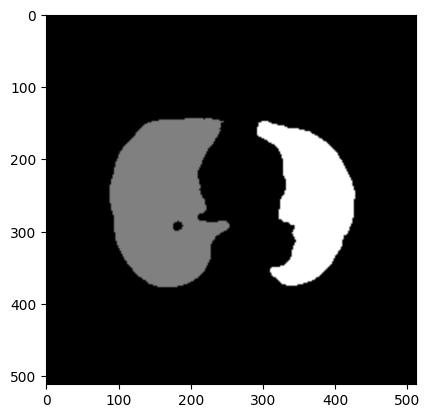

Left lung dice coefficient: 0.9579226855853848, Right lung dice coefficient: 0.8832068565306669, Body masks dice coefficient: 0.9901414724453385
Left lung hausdorff: 13.2664991614216, Right lung hausdorff: 18.05547008526779, Body masks hausdorff: 2.23606797749979


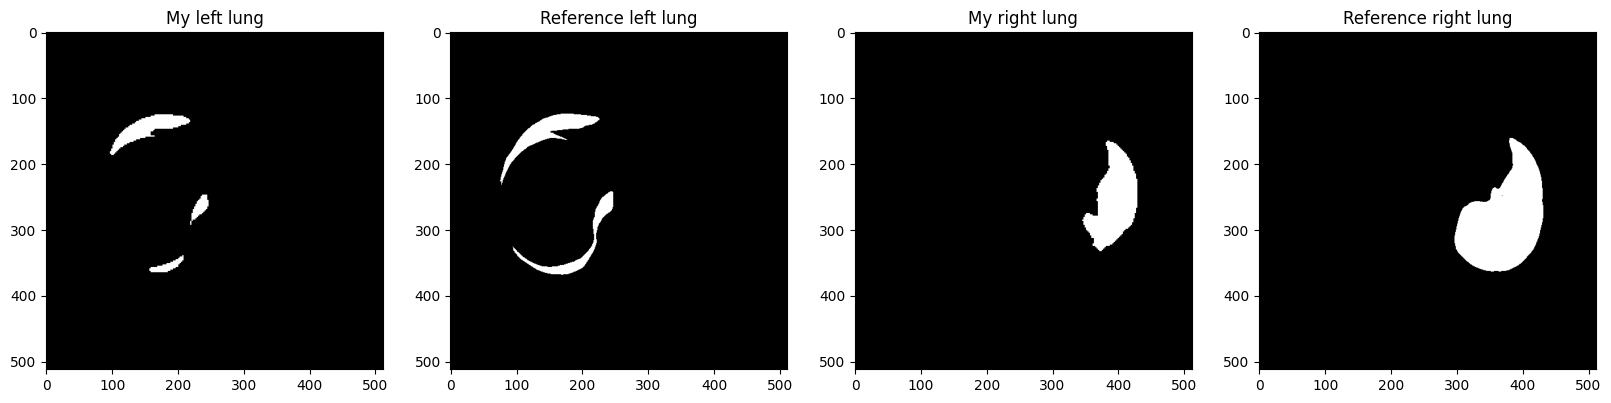

~~~ Images/IMG_0012.nii.gz ~~~
Custom threshold:  85
Visualizing cut image


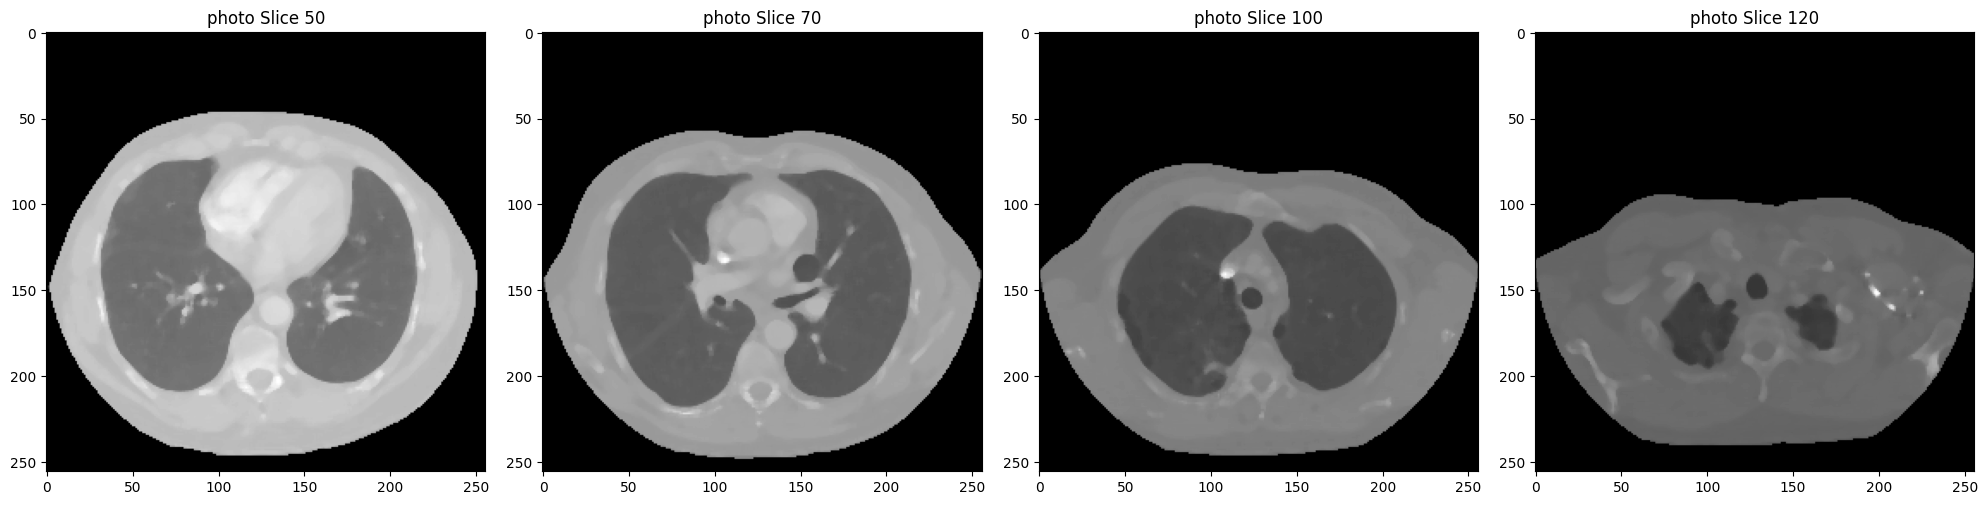

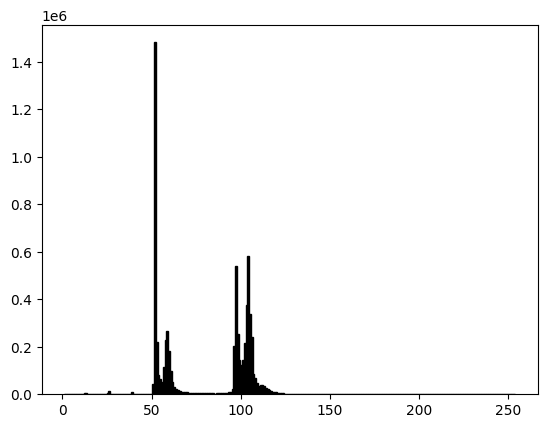

Lung peak value: 51.9140625
Visualizing lungs


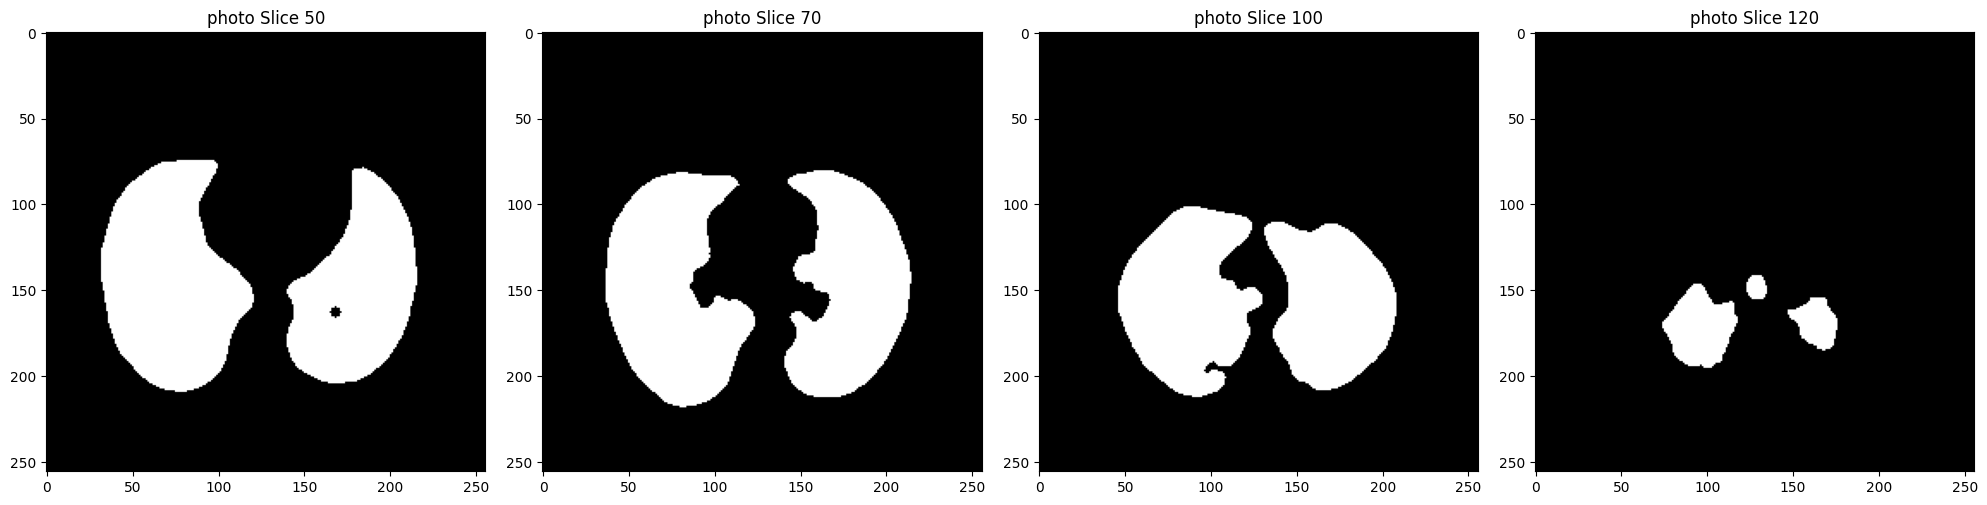

Center point (np.int64(153), np.int64(78), np.int64(71))
Center point (np.int64(151), np.int64(175), np.int64(69))
Visualizing watershed


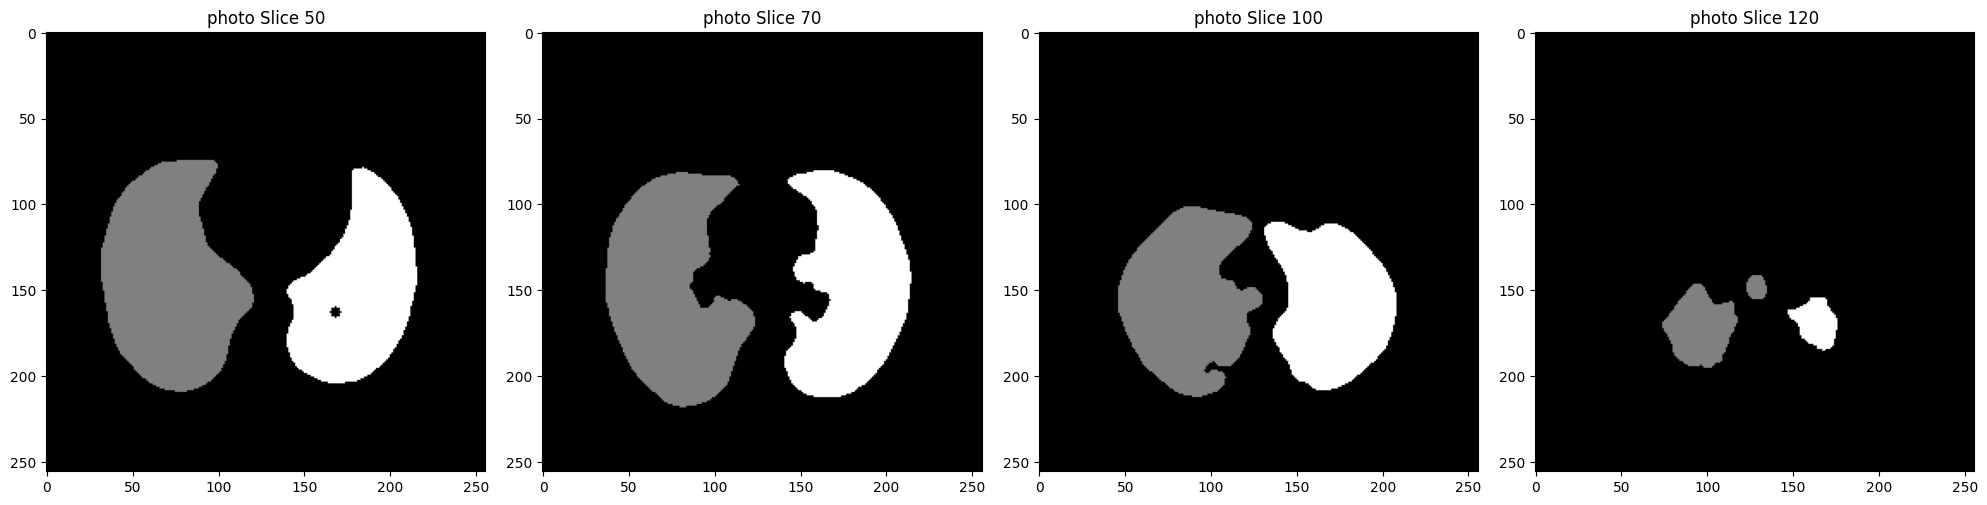

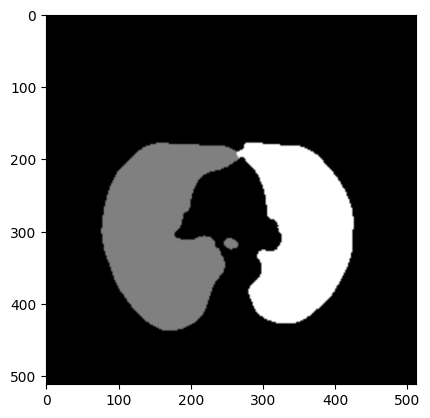

Left lung dice coefficient: 0.9628090888182531, Right lung dice coefficient: 0.9700864824587859, Body masks dice coefficient: 0.9927254688774332
Left lung hausdorff: 8.0, Right lung hausdorff: 4.242640687119285, Body masks hausdorff: 2.449489742783178


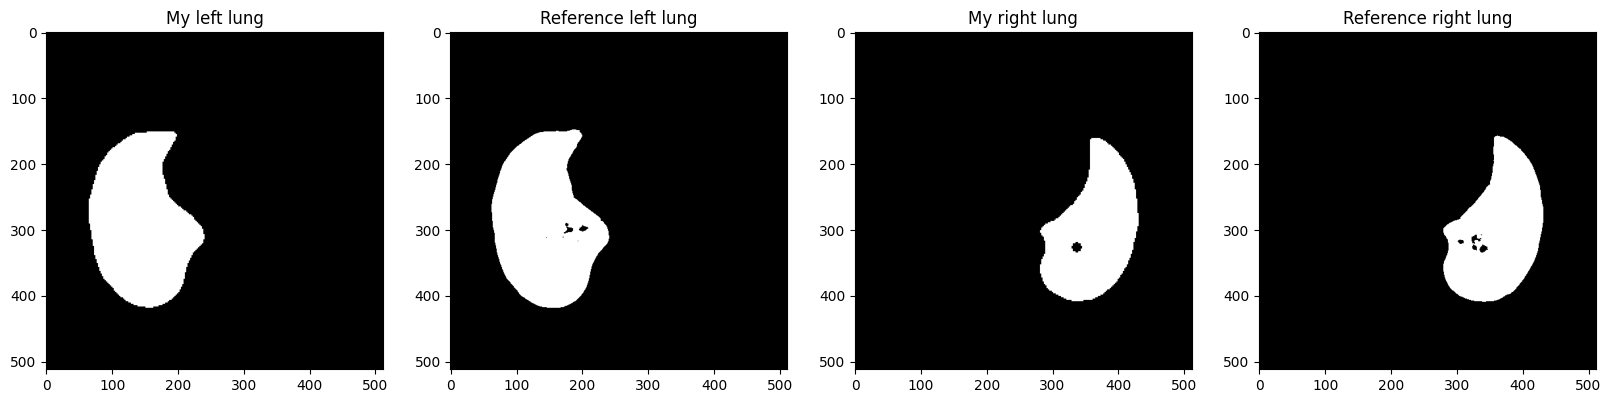

~~~ Images/IMG_0013.nii.gz ~~~
Custom threshold:  85
Visualizing cut image


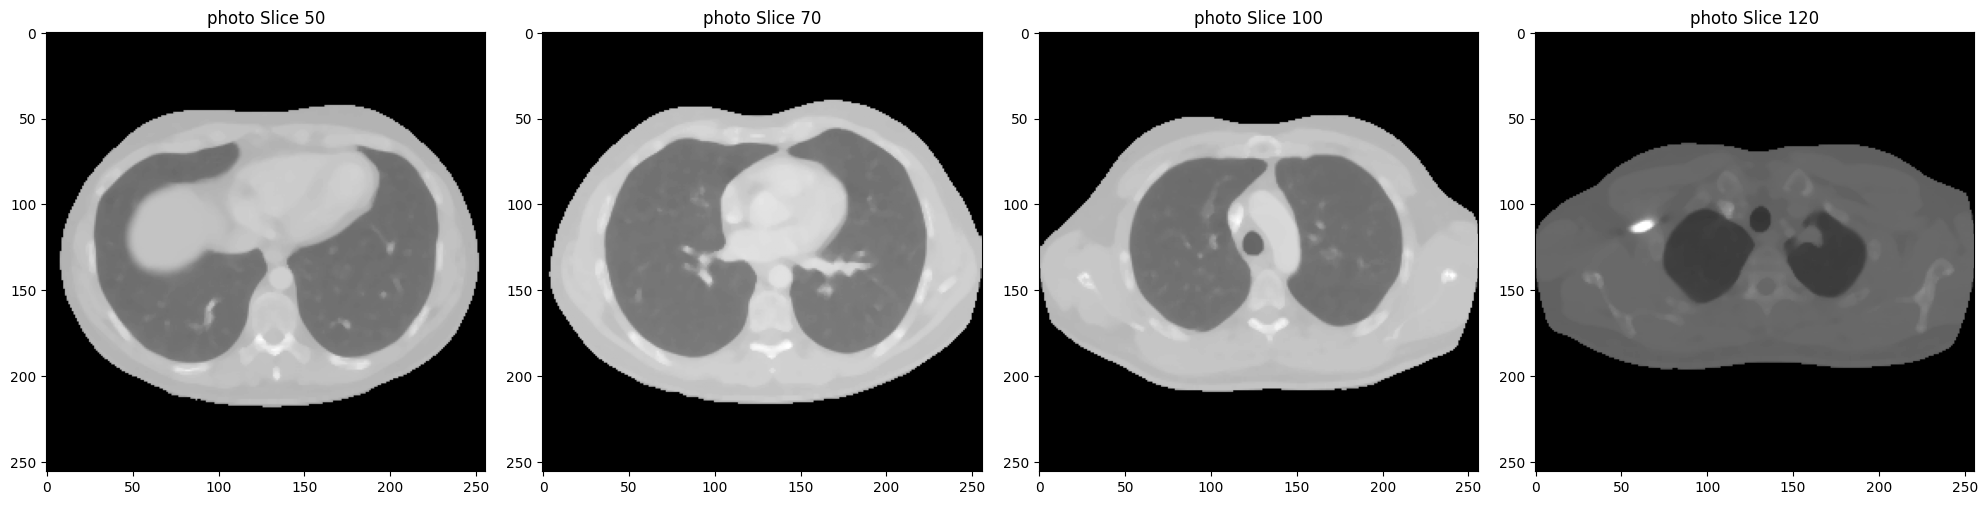

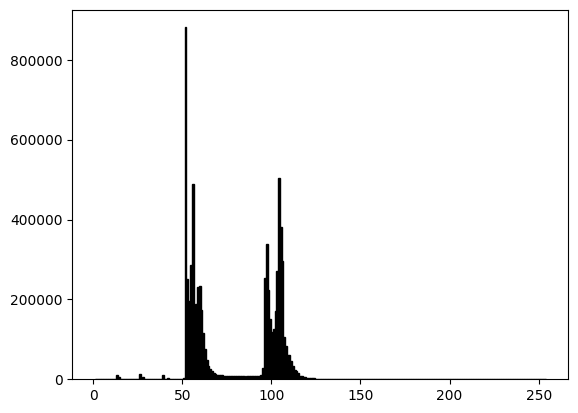

Lung peak value: 51.9140625
Visualizing lungs


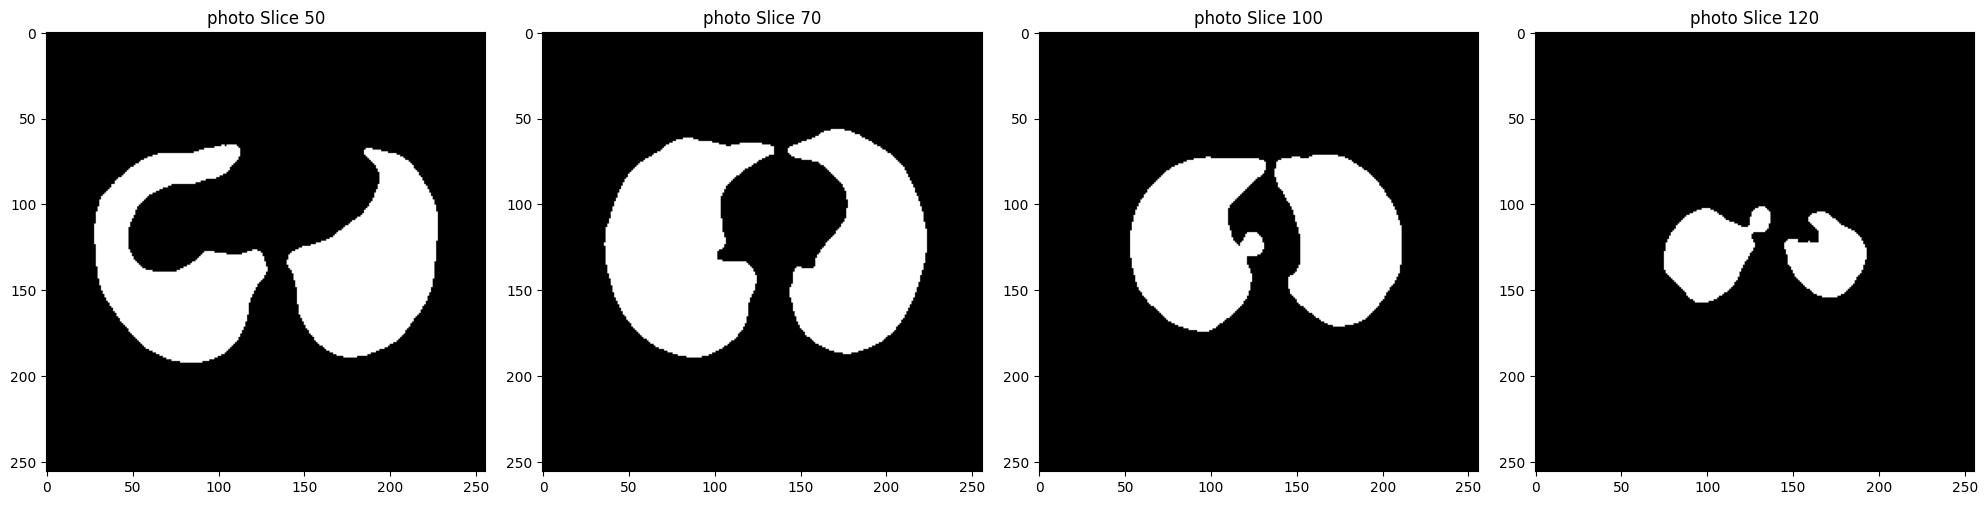

Center point (np.int64(128), np.int64(84), np.int64(76))
Center point (np.int64(125), np.int64(182), np.int64(75))
Visualizing watershed


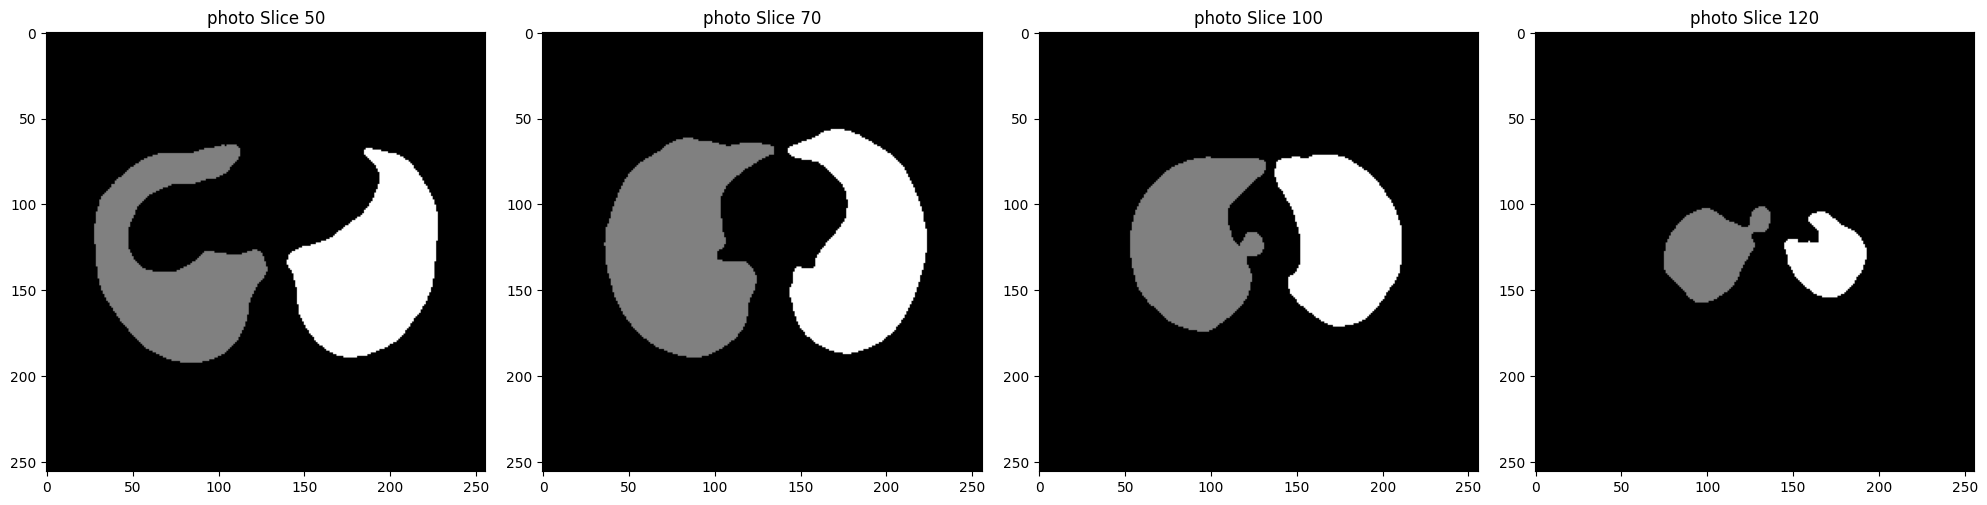

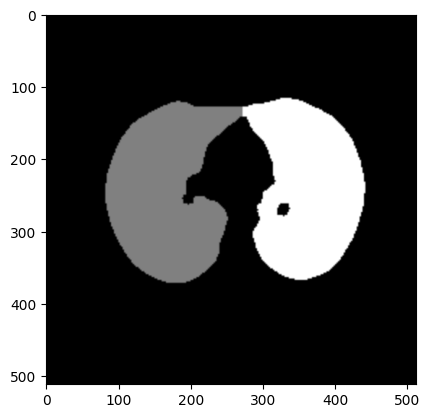

Left lung dice coefficient: 0.9631902658936073, Right lung dice coefficient: 0.953765036108983, Body masks dice coefficient: 0.9911008277632916
Left lung hausdorff: 5.385164807134504, Right lung hausdorff: 8.0, Body masks hausdorff: 2.23606797749979


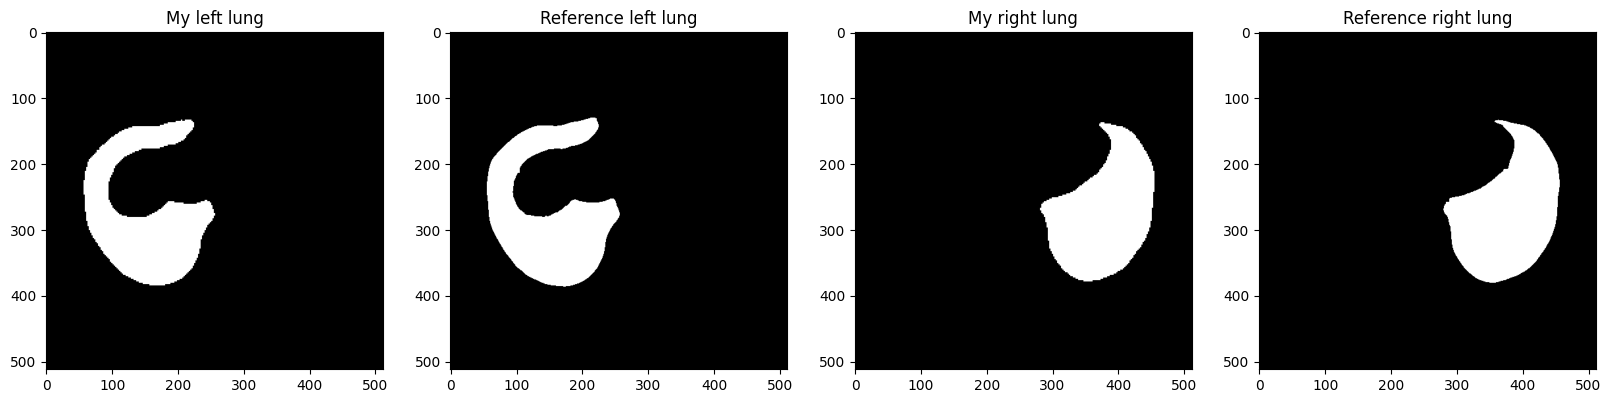

~~~ Images/IMG_0014.nii.gz ~~~
Custom threshold:  86
Visualizing cut image


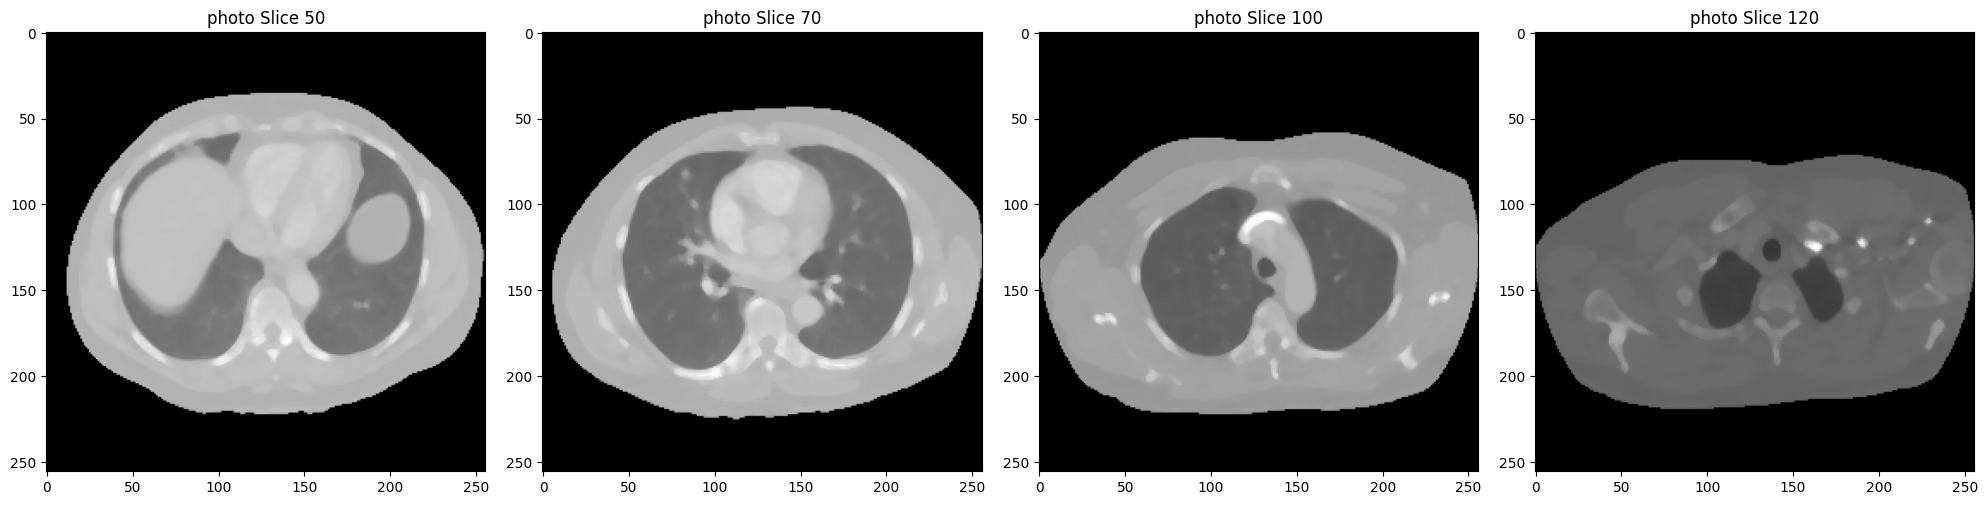

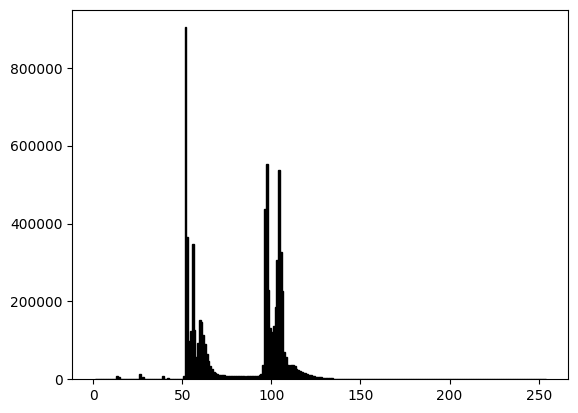

Lung peak value: 51.95703125
Visualizing lungs


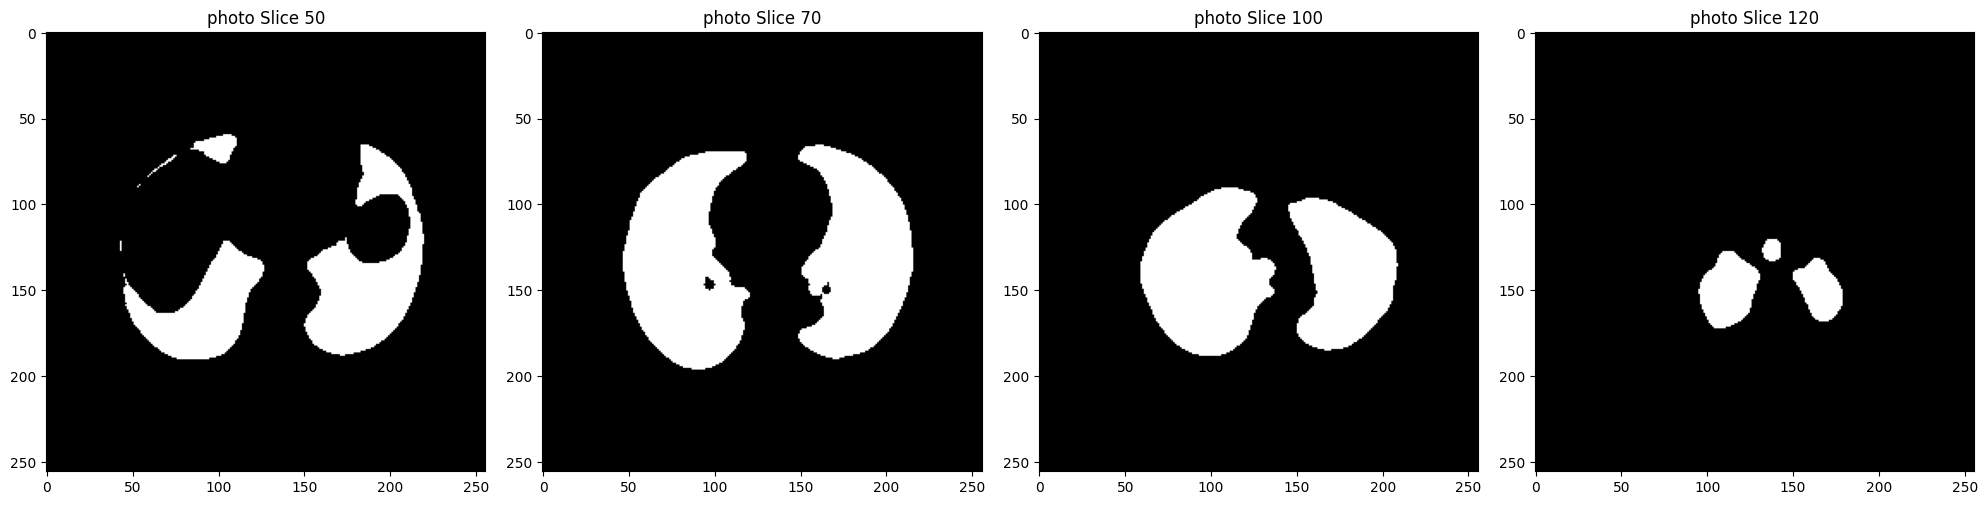

Center point (np.int64(135), np.int64(90), np.int64(77))
Center point (np.int64(129), np.int64(177), np.int64(72))
Visualizing watershed


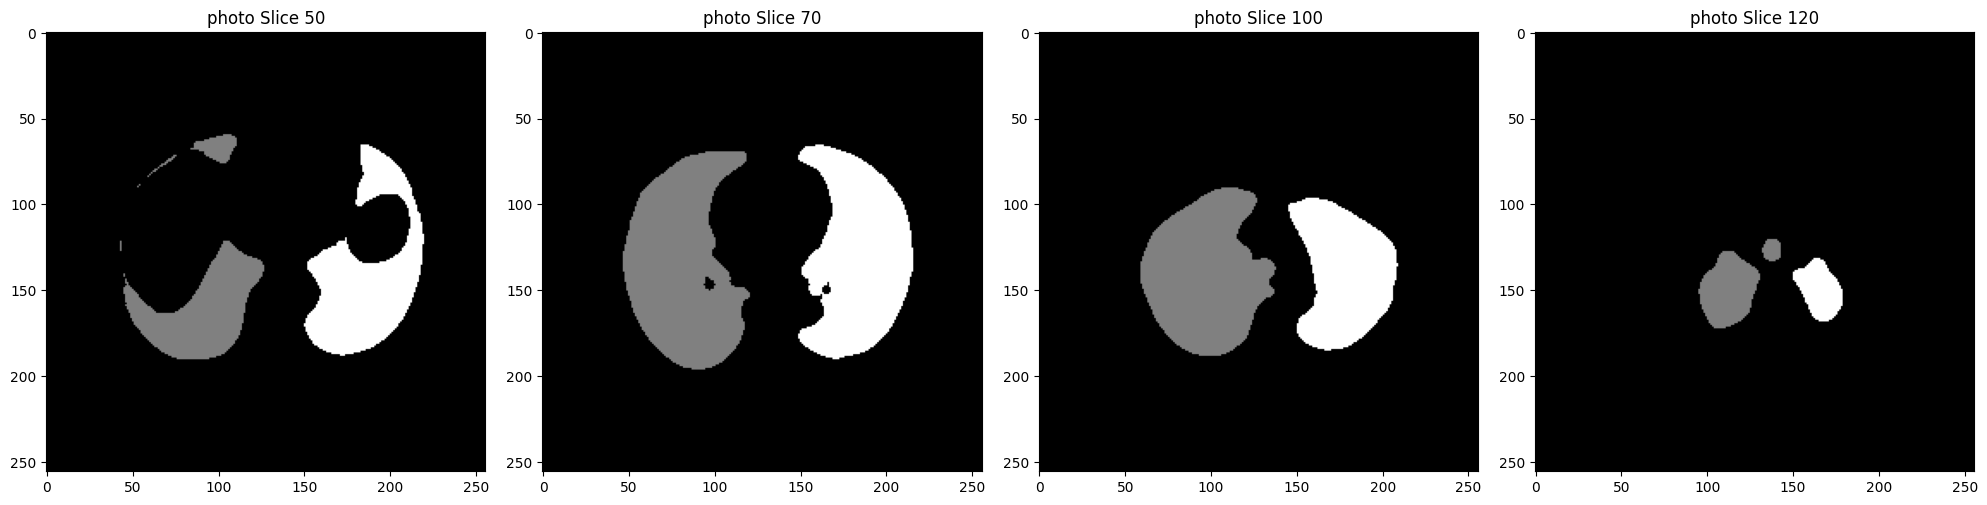

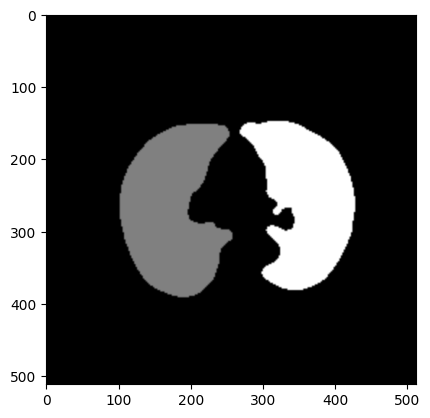

Left lung dice coefficient: 0.9538856633142239, Right lung dice coefficient: 0.9561938532049529, Body masks dice coefficient: 0.9924234802734128
Left lung hausdorff: 5.477225575051661, Right lung hausdorff: 6.0, Body masks hausdorff: 2.0


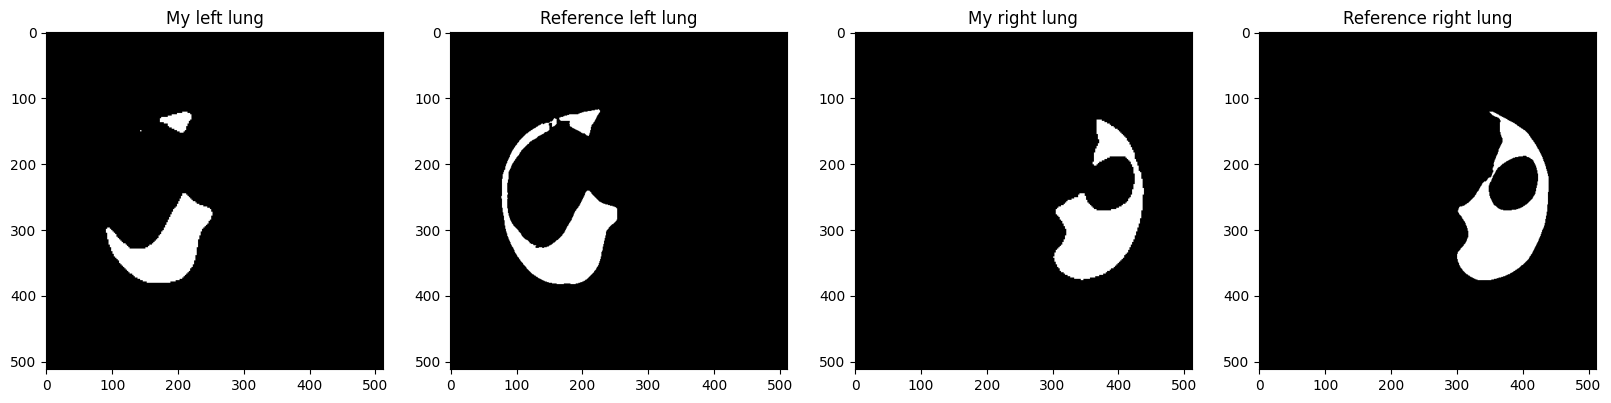

Average left lung dice coefficient: 0.9601127541405189, Average right lung dice coefficient: 0.9501469801470603, Average body masks dice coefficient: 0.9913815645229663


In [126]:
# run('Images/IMG_0001.nii.gz','ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0001.nii.gz', 'output_0001.nii.gz')
# run('Images/IMG_0007.nii.gz','ReferenceSegmentations/LUNGS_IMG_0007.nii.gz', 'BodyMasks/BODYMASK_IMG_0007.nii.gz', 'output_0007.nii.gz')
# run('Images/IMG_0010.nii.gz','ReferenceSegmentations/LUNGS_IMG_0010.nii.gz', 'BodyMasks/BODYMASK_IMG_0010.nii.gz', 'output_0010.nii.gz')
# run('Images/IMG_0011.nii.gz','ReferenceSegmentations/LUNGS_IMG_0011.nii.gz', 'BodyMasks/BODYMASK_IMG_0011.nii.gz', 'output_0011.nii.gz')
# run('Images/IMG_0012.nii.gz','ReferenceSegmentations/LUNGS_IMG_0012.nii.gz', 'BodyMasks/BODYMASK_IMG_0012.nii.gz', 'output_0012.nii.gz')
# run('Images/IMG_0013.nii.gz','ReferenceSegmentations/LUNGS_IMG_0013.nii.gz', 'BodyMasks/BODYMASK_IMG_0013.nii.gz', 'output_0013.nii.gz')
# run('Images/IMG_0014.nii.gz','ReferenceSegmentations/LUNGS_IMG_0014.nii.gz', 'BodyMasks/BODYMASK_IMG_0014.nii.gz', 'output_0014.nii.gz')

inputs = ['Images/IMG_0001.nii.gz', 'Images/IMG_0007.nii.gz', 'Images/IMG_0010.nii.gz', 'Images/IMG_0011.nii.gz', 'Images/IMG_0012.nii.gz', 'Images/IMG_0013.nii.gz', 'Images/IMG_0014.nii.gz']
references = ['ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0007.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0010.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0011.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0012.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0013.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0014.nii.gz']
body_masks = ['BodyMasks/BODYMASK_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0007.nii.gz', 'BodyMasks/BODYMASK_IMG_0010.nii.gz', 'BodyMasks/BODYMASK_IMG_0011.nii.gz', 'BodyMasks/BODYMASK_IMG_0012.nii.gz', 'BodyMasks/BODYMASK_IMG_0013.nii.gz', 'BodyMasks/BODYMASK_IMG_0014.nii.gz']

run_all_tests(inputs, references, body_masks)